The headers for the table activity_Schedule are shown below:

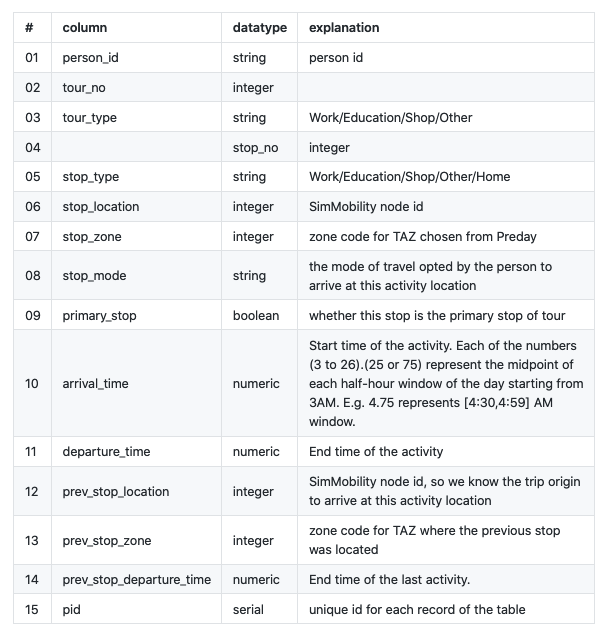

In [104]:
calibrating_on_small_sample = False
regenerate_graphs = True 
load_graphs_in_RAM = True
store_graphs_folder_name = 'FOR_IDO'
index_start = {}
index_start['PID'] = 0
index_start['NODE'] = 10000000
index_start['HHID'] = 20000000
index_start['BUSLINE_TRIPNUM'] = 30000000
index_start['MRTLINE_TRIPNUM'] = 40000000
index_start['WORK_NODE'] = 50000000
index_start['EDUCATION_NODE'] = 60000000
index_start['SHOPPING_NODE'] = 70000000
index_start['OTHER_NODE'] = 80000000
HOW_MANY_PEOPLE = 1000  # set to -1 for running on full population

In [105]:
# %cd ~/c/dfcr/AI
! cp AI/* ./
! gunzip -f  *.gz
! mkdir FOR_IDO
! mkdir FOR_IDO/ACT_dicts
! mkdir FOR_IDO/PT_dicts
! mkdir FOR_IDO/HOME_dicts
! mkdir FOR_IDO/UNION_dicts

mkdir: cannot create directory ‘FOR_IDO’: File exists
mkdir: cannot create directory ‘FOR_IDO/ACT_dicts’: File exists
mkdir: cannot create directory ‘FOR_IDO/PT_dicts’: File exists
mkdir: cannot create directory ‘FOR_IDO/HOME_dicts’: File exists
mkdir: cannot create directory ‘FOR_IDO/UNION_dicts’: File exists


In [106]:
 
node_lat_lon = {}
node_dict = {}
index = index_start['NODE']
with open('AI_node_lat_lon.csv') as f:
    for row in f:
        listed = row.strip().split(',')
        node_lat_lon[int(listed[0])] = [float(listed[1]), float(listed[2])]
        if int(listed[0]) not in node_dict:
            node_dict[int(listed[0])] = index 
            index += 1


voronoi_area = {}
with open('AI_node_area_using_grids.csv') as f:
    for row in f:
        listed = row.strip().split(',')
        voronoi_area[int(listed[0])] = float(listed[1])

node_wise_A = {}
for node in node_dict:
    if node in voronoi_area:
        node_wise_A[node_dict[node]] = voronoi_area[node]
    else:
        node_wise_A[node_dict[node]] = sum(voronoi_area.values())/len(voronoi_area)


In [107]:
# get mode shares from DAS
modes_share = {}
with open('AI_demand_BC.csv') as f:
    for row in f:
        listed = row.strip().split(',')
        stop_mode = listed[7]
        if stop_mode in modes_share:
            modes_share[stop_mode] += 1
        else:
            modes_share[stop_mode] = 1
s = sum(modes_share.values())
for mode in modes_share:
    modes_share[mode] /= s 
    print (mode, round(modes_share[mode]*100,2), '%')


Car 47.57 %
Car Sharing 2 17.62 %
Car Sharing 3 13.02 %
BusTravel 9.4 %
SMS 4.31 %
Walk 4.24 %
Taxi 0.77 %
PrivateBus 0.66 %
Motorcycle 1.21 %
Bike 1.21 %


In [108]:
# CREATE SMALL DAS AND TT.csv for 100K people
# COMMENT WHEN NOT CALIBRATING
import csv

import random

# if calibrating_on_small_sample :
hhidlist = []
hhid = {}
with open('AI_individual.csv') as f:
    next(f)
    for row in f:
        listed = row.strip().split(',')
        hhidlist.append(int(listed[3]))
        pid = listed[0] + "-1"
        hhid[pid] = int(listed[3])
        
hhidlist = list(set(hhidlist))
random.shuffle(hhidlist)
hhidlist = set(hhidlist[:HOW_MANY_PEOPLE])
hhidlist = set(hhidlist)

pid_list = [] 
with open('AI_individual.csv') as f:
    next(f)
    with open('tt','w') as f2:
        csvwriter = csv.writer(f2)
        for row in f:
            listed = row.strip().split(',')
            pid = listed[0] + "-1"
            if int(listed[3]) in hhidlist:
                csvwriter.writerow(listed)
                pid_list.append(pid)
! mv tt AI_individual.csv

pid_list = list(set(pid_list))
# random.shuffle(pid_list)
pid_list = set(pid_list)


pidDict = {}
pid_list = list(pid_list)
reverse_pidDict = {}
for i in range(len(pid_list)):
    pidDict[pid_list[i]] = i
    reverse_pidDict[i] = pid_list[i]


modes_share = {}
with open('AI_demand_BC') as f:
    next(f)
    with open('tt','w') as f2:
        csvwriter = csv.writer(f2)
        for row in f:
            listed = row.strip().split(',')
            pid = listed[0]
            if hhid[pid] in hhidlist:
                csvwriter.writerow(listed)
! mv tt AI_demand_BC.csv




with open('traveltime.csv') as f:
    with open('tt','w') as f2:
        csvwriter = csv.writer(f2)
        for row in f:
            listed = row.strip().split(',')
            pid = listed[0]
            if pid not in hhid:
                continue
            if hhid[pid] in hhidlist:
                csvwriter.writerow(listed)
!mv tt traveltime.csv                



hhid_unique_ids = []
with open('AI_individual.csv') as f:
    for row in f:
        listed = row.strip().split(',')
        hhid_unique_ids.append(int(listed[3]))

hhid_unique_ids = list(set(hhid_unique_ids))
hhidDict = {}
reverse_hhidDict = {}
for i in range(len(hhid_unique_ids)):
    hhidDict[hhid_unique_ids[i]] = i + index_start['HHID']
    reverse_hhidDict[i + index_start['HHID']] = hhid_unique_ids[i]        
    
age = {}
hhid = {}
with open('AI_individual.csv') as f:
    for row in f:
        listed = row.strip().split(',')
        pid = listed[0]+"-1"
        age[pidDict[pid]] = int(listed[11])
        hhid[pidDict[pid]] = hhidDict[int(listed[3])]
        
hhid_pid_list = {}
for pid in hhid:
    if hhid[pid] not in hhid_pid_list:
        hhid_pid_list[hhid[pid]] = [pid]
    else:
        hhid_pid_list[hhid[pid]].append(pid)


In [109]:
import gc
backup_states = {}
backup_states_loaded = {}
gc.collect()

4216

In [110]:
import pickle
! mkdir running_statevectors2
with open('running_statevectors2/hhid.pickle', 'wb') as handle:
    pickle.dump(hhid, handle, protocol=pickle.HIGHEST_PROTOCOL) 
with open('running_statevectors2/age.pickle', 'wb') as handle:
    pickle.dump(age, handle, protocol=pickle.HIGHEST_PROTOCOL)    
with open('running_statevectors2/pidDict.pickle', 'wb') as handle:
    pickle.dump(pidDict, handle, protocol=pickle.HIGHEST_PROTOCOL) 

mkdir: cannot create directory ‘running_statevectors2’: File exists


In [111]:
import pickle
with open('running_statevectors2/pidDict.pickle','rb') as handle:
    pidDict = pickle.load(handle) 
with open('running_statevectors2/hhid.pickle','rb') as handle:
    hhid = pickle.load(handle) 
with open('running_statevectors2/age.pickle','rb') as handle:
    age = pickle.load(handle) 

In [112]:
income = {}
with open('AI_individual.csv') as f:
    for row in f:
        listed = row.strip().split(',')
        pid = listed[0]+"-1"
        income[pidDict[pid]] = int(listed[14])
income_map = {1:'Less than 15,000',2:'15,000 - 24,999',3:'25,000 - 34,999',4:'35,000 - 49,999',5:'50,000 - 74,999',6:'75,000 - 99,999',7:'100,000 - 149,999',8:'150,000'}

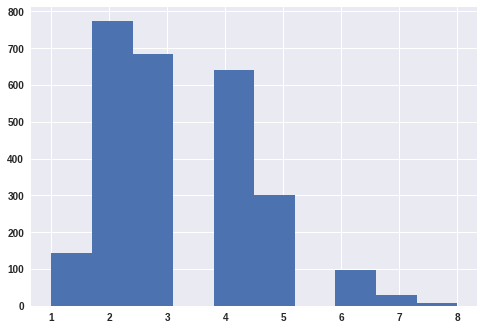

In [113]:
import matplotlib.pyplot as plt
c = 0 
a = []
for  key in hhid.values():
    a.append(len(hhid_pid_list[key]))
plt.hist(a,10)
plt.show()

In [114]:
#####################################################
############### HOME LOCATION GRAPH #################
#####################################################
import csv
import time
import pickle
import numpy as np

globalTime = time.time()
if regenerate_graphs:
    hopsize = 1
    count = 0
    for sttt in range(0,hopsize):
        forwardDict = {}
        backwardDict = {}
        for pid in hhid:
            if count % 10000 == 0:
                print (count, 'PIDs processed')
            count += 1
            for time_slots in range(sttt,288,hopsize):
                if time_slots not in forwardDict:
                    forwardDict[time_slots] = {}
                forwardDict[time_slots][pid] = hhid[pid] 
                if time_slots not in backwardDict:
                    backwardDict[time_slots] = {}
                if hhid[pid] in backwardDict[time_slots]:
                    backwardDict[time_slots][hhid[pid]].append(pid)
                else:
                    backwardDict[time_slots][hhid[pid]] = [pid]

        for time_slots in range(sttt,288,hopsize) :
            d = {}
            d['forward'] = forwardDict[time_slots]
            d['backward'] = backwardDict[time_slots]

            with open(store_graphs_folder_name+'/HOME_dicts/home_dict_'+str(time_slots)+'.pickle', 'wb') as handle:
                pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)        

        print ("Graphs saved ", (sttt,288,hopsize))

0 PIDs processed
Graphs saved  (0, 288, 1)


In [115]:
import csv
import time
import matplotlib.pyplot as plt 
import pickle
import numpy as np
import gc
import networkx as nx


# Filename: Activity_schedule
"""
create a list of pids persons from traveltime.csv 
We also create two dictionaries; 
(1) PID->(node->[start_time, end_time])
(2) PID->(lat_lon) for home location and plotting purposes (For this we take help of node-> lat_lon table )
"""


das_mem = []
with open('AI_demand_BC.csv') as f:
    for row in f:
        listed = row.strip().split(',')

        stop_node = int(listed[5])
        stop_zone = int(listed[6])
        prev_stop_node = int(listed[11])
        prev_stop_zone = int(listed[12])
        ## nodes with missing data
        if stop_node == 0 or stop_node == 8165 or prev_stop_node == 0 or prev_stop_node == 8165:
            continue

        das_mem.append(row.strip().split(','))



In [116]:
aaa = []
act_type = {}
with open('AI_demand_BC.csv') as f:
    for row in f:
        listed = row.strip().split(',')
        if listed[4] == 'Home':
            continue
        if listed[4] in act_type:
            act_type[listed[4]] += 1
        else:
            act_type[listed[4]] = 1
        aaa.append(pidDict[listed[0]])
s = sum(act_type.values())
for key in act_type:
    print (key, round(act_type[key]/s*100,2))
print (len(set(aaa)))

Other 47.49
Work 24.27
Education 12.43
Shop 15.8
2228


In [117]:
aa = set(aaa)
c = []
for key in hhid:
    if key not in  aa:
        c.append(key)
print (len(set(c)))

446


In [118]:
countMissing = 0
notMissing = 0 
debug = []
index = 0
numpy_das = []
!mkdir ACT_dicts

import csv
import time
import matplotlib.pyplot as plt 
import pickle
import numpy as np
import gc
import networkx as nx


def cantor(a,b):
    # http://szudzik.com/ElegantPairing.pdf
    if a >= b:
        return a * a + a + b
    else:
        return a + b * b
    

globalTime = time.time()
regenerate_graphs = True

if regenerate_graphs:
    hopsize = 6
    for sttt in range(0,hopsize):
        forwardDict = {}
        backwardDict = {}
        count = 1
        relevant_ts = set(range(sttt,288,hopsize))

        for listed in das_mem:    
            count += 1
            if count % 100000 == 0:
                print (count, "lines_processed in  ",time.time()-globalTime )

            listed = list(listed)
            # listed = row.strip().split(',')
            stop_type = listed[4]
            if stop_type == 'Home':
                continue  # this is taken care of by the HHID
            stop_node = int(listed[5])
            node_seq = node_dict[stop_node]

            if stop_type == 'Work':
                node_seq += index_start['WORK_NODE']
            if stop_type == 'Education':
                node_seq += index_start['EDUCATION_NODE']
            if stop_type == 'Shop':
                node_seq += index_start['SHOPPING_NODE']
            if stop_type == 'Other':
                node_seq += index_start['OTHER_NODE']
                
            pid = listed[0]
            stop_arrival_time = float(listed[9])
            stop_departure_time = float(listed[10])
            start_5_min_slot = int((int(stop_arrival_time) * 60 + (stop_arrival_time - int(stop_arrival_time) -0.25 )*60) // 5 ) # % (1440//5)
            end_5_min_slot = int((int(stop_departure_time) * 60 + (stop_departure_time - int(stop_departure_time) -0.25 )*60) // 5 ) # % (1440//5)
            if end_5_min_slot >= (1440//5):
                end_5_min_slot = 1440//5 -1 
            activity_dur = (end_5_min_slot - start_5_min_slot) 

            listed[9] = start_5_min_slot # + round(6*np.random.rand())
            listed[10] = end_5_min_slot # + round(6*np.random.rand())
            if listed[10] == listed[9]:
                listed[10] += 1
            if listed[10] >= (1440//5):
                listed[10] = 1440//5 -1 
            if listed[9] >= (1440//5):
                listed[9] = 1440//5 -1


            for time_slots in range(listed[9] , listed[10] ):
                if time_slots not in relevant_ts:
                    continue
                    
                if time_slots not in forwardDict:
                    forwardDict[time_slots] = {}
                forwardDict[time_slots][pidDict[pid]] = node_seq # cantor(time_slots, ) # str(time_slots)+'_dummy_'+str(stop_node)
                if time_slots not in backwardDict:
                    backwardDict[time_slots] = {}
                if node_seq in backwardDict[time_slots]:
                    backwardDict[time_slots][node_seq].append(pidDict[pid])
                else:
                    backwardDict[time_slots][node_seq] = [pidDict[pid]]

        for time_slots in range(sttt,288,hopsize) :
            if time_slots not in forwardDict:
                forwardDict[time_slots] = {}
            if time_slots not in backwardDict:
                backwardDict[time_slots] = {}
            d = {}
            d['forward'] = forwardDict[time_slots]
            d['backward'] = backwardDict[time_slots]

            with open(store_graphs_folder_name+'/ACT_dicts/act_dict_'+str(time_slots)+'.pickle', 'wb') as handle:
                pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)        

        print ("Graphs saved ", (sttt,288,hopsize))

mkdir: cannot create directory ‘ACT_dicts’: File exists
Graphs saved  (0, 288, 6)
Graphs saved  (1, 288, 6)
Graphs saved  (2, 288, 6)
Graphs saved  (3, 288, 6)
Graphs saved  (4, 288, 6)
Graphs saved  (5, 288, 6)


In [119]:
import gc
gc.collect()

22

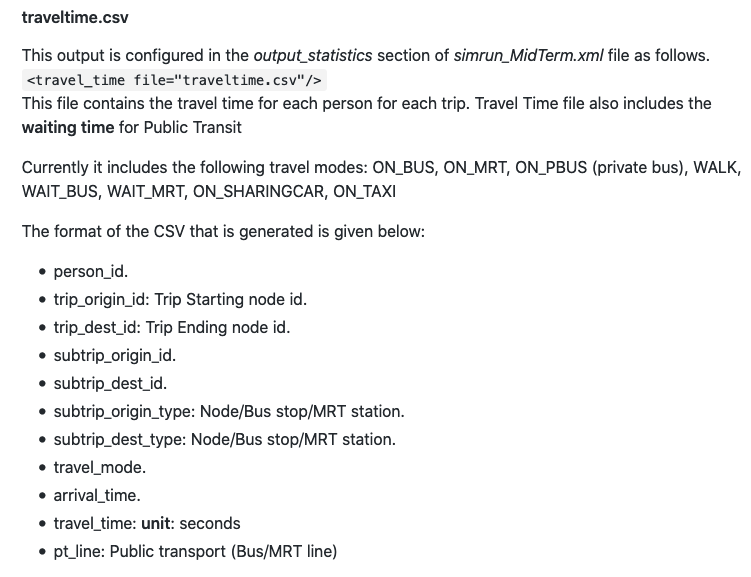

In [120]:
import numpy as np
import csv
import time

"""
Table: journey_time
Column name 	Data Type 	Description
0  pt_stop_id 	character (50) 	PT stop ID
1  pt_line_id 	character (50) 	PT line ID
2  trip_id 	integer 	Run number ID of that PT line
3  pc_occ 	double precision 	Percentage of occupancy of that vehicle at that stop
4  sequence_id 	integer 	Sequence ID of the stop in the route of the PT line
5  arrival_time 	time without time zone 	Arrival time of the vehicle at that stop
6  waiting_time 	time without time zone 	Waiting/dwell time of vehicle at that stop
"""
# ! gunzip journeytime.csv.gz
# ! head -n 1000 journeytime.csv

# creating a map with 
# key: (<bus_line>, <stop id>, <time_slot>) 
# value: (<bus_line>, <trip_id_of_bus>) 
M_JT = {}  # Map from journeytime.csv file
a = []
with open('journeytime.csv') as f:
    for row in f:
        listed = row.strip().split(',')
        
        arr_t = (listed[5])
        hh,mm,ss = arr_t.split(':')
        ss = int(hh) * 3600 + int(mm) * 60 + int(ss)
        M_JT[(listed[1], (listed[0]), int(ss//(300)))] = ( listed[1], int(listed[2])) # 5 minute intervals: 60*5 = 300 seconds
print (len(M_JT.keys()))



"""
Filename: Traveltime.csv
This output is configured in the output_statistics section of simrun_MidTerm.xml file as follows.
<travel_time file="traveltime.csv"/>
This file contains the travel time for each person for each trip. Travel Time file also includes the waiting time for Public Transit

Currently it includes the following travel modes: ON_BUS, ON_MRT, ON_PBUS (private bus), WALK, WAIT_BUS, WAIT_MRT, ON_SHARINGCAR, ON_TAXI

The format of the CSV that is generated is given below:

   0 person_id.
   1 trip_origin_id: Trip Starting node id.
   2 trip_dest_id: Trip Ending node id.
   3 subtrip_origin_id.
   4 subtrip_dest_id.
   5 subtrip_origin_type: Node/Bus stop/MRT station.
   6 subtrip_dest_type: Node/Bus stop/MRT station.
   7 travel_mode.
   8 arrival_time.
   9 travel_time: unit: seconds
  10 pt_line: Public transport (Bus/MRT line)


Expanded Traveltime.csv because of these scenarios
4043757-1,52107,54976,475,483,BS,BS,WAIT_BUS,06:01:55,205,23_0_230065/23_0_230067/23_0_230071/23_0_230070

"""
different_names = {}
with open('tt_expanded.csv','w') as f:
    csvwriter = csv.writer(f)
    with open('traveltime.csv') as f2:
        for row in f2:
            listed = row.strip().split(',')
            if listed[7] not in ['ON_BUS', 'ON_MRT','WAIT_MRT', 'WAIT_BUS']:
                continue            
            if '/' in listed[3]:
                listed_3_expanded = listed[3].split('/')
            else:
                listed_3_expanded = [listed[3]]
                
            if '/' in listed[10]:
                listed_10_expanded = listed[10].split('/')
            else:
                listed_10_expanded = [listed[10]]
                
            for i in listed_3_expanded:
                for j in listed_10_expanded:
                    tt = list(listed)
                    if listed[7] in ['ON_MRT']:  #'WAIT_MRT' is already updated; no need to change here again
                        tt[3] = i + "_"+ j.split('_')[1] 
                    else:
                        tt[3] = i
                    tt[10] = j
                    csvwriter.writerow(tt)
                



276008


In [121]:
! grep 'WAIT_MRT' traveltime.csv | head -n 10

3841712-1,60377,58723,Orange9_1,Orange16_1,PT,PT,WAIT_MRT,06:47:30,270,Orange_1
4114532-1,54199,53733,Mattapan1_1,Mattapan7_1,PT,PT,WAIT_MRT,07:18:15,130,Mattapan_1
3992640-1,54712,44503,Green-E14_2,Green-E9_2,PT,PT,WAIT_MRT,07:11:25,560,Green-E_2
3992640-1,54712,44503,Green-B21_2,Green-B7_2,PT,PT,WAIT_MRT,07:26:35,45,Green-B_2
1723193-1,40416,60888,Orange20_2,Orange19_2,PT,PT,WAIT_MRT,07:17:25,600,Orange_2
3775053-1,55464,56979,Green-B20_2,Green-B11_2,PT,PT,WAIT_MRT,07:35:05,460,Green-B_2
4248428-1,46115,46547,Green-D-Riverside6_1,Green-D-Riverside11_1,PT,PT,WAIT_MRT,07:49:50,60,Green-D-Riverside_1
3773890-1,59546,59205,Green-E11_2,Green-E8_2,PT,PT,WAIT_MRT,07:46:55,320,Green-E_2
3954934-1,58818,59511,Green-E1_1,Green-E11_1,PT,PT,WAIT_MRT,08:02:00,85,Green-E_1
2333418-1,48713,48831,Green-D-Riverside5_1,Green-D-Riverside6_1,PT,PT,WAIT_MRT,08:03:00,55,Green-D-Riverside_1
grep: write error: Broken pipe


In [122]:


"""
S_keys : a dictionary to map all spatial keys to numbers ; 
for travel modes in [ON_MRT, ON_BUS], the spatial identifier is (<Bus/MRT Line>,<>)
"""

import time
startTime = time.time()
S_keys = {}
count_mismatches = 0 
count_matches = 0 
max_slide = 0 
index_bus = index_start['BUSLINE_TRIPNUM'] 
index_mrt = index_start['MRTLINE_TRIPNUM'] 
unique_bus_mrt_lines = []
pt_location_wise_A = {}
validLinesCount = 0
ccc = 0 
with open('tt_expanded.csv') as f:
    for row in f:
        listed = row.strip().split(',')

        if listed[7] not in [ 'ON_MRT', 'ON_BUS','WAIT_MRT', 'WAIT_BUS']:
            continue

        pid = listed[0]
        arr_t = (listed[8])
        hh,mm,ss = arr_t.split(':')
        ss = int(hh) * 3600 + int(mm) * 60 + int(ss)

        strt_t = ss - int(listed[9])   

        arr_five_min_int = ss // 300
        start_five_min_int = strt_t // 300
        
        st_key = (listed[10], listed[3], arr_five_min_int)
        # print (st_key)
        
        problematicRow = False
        if st_key not in M_JT:
            tt = st_key[2]
            counter = 0 
            while((st_key[0], st_key[1], tt)) not in M_JT:
                tt -= 1
                counter += 1
                if counter > 1:
                    problematicRow = True
                    break
            if max_slide < st_key[2] - tt :
                max_slide = st_key[2] - tt                   
            st_key = (st_key[0], st_key[1], tt) 
        if problematicRow:
            continue
        else:
            validLinesCount += 1
        
        if st_key not in M_JT:
            continue
        pt_line_trip_id = M_JT[st_key]
        
        
        if pt_line_trip_id not in S_keys:
            if listed[7] in [ 'ON_MRT', 'WAIT_MRT']: # , 'WAIT_BUS']:'ON_BUS'
                S_keys[pt_line_trip_id] = index_mrt 
                index_mrt += 1
            if listed[7] in [ 'ON_BUS', 'WAIT_BUS']: # , 'WAIT_BUS']:'ON_BUS'
                S_keys[pt_line_trip_id] = index_bus 
                index_bus += 1
            
#             if listed[7] in ['ON_BUS', 'WAIT_BUS']:
#                 pt_location_wise_A[index] = ( 1/4 * 11.95 * 2.55 )  #  taken from https://www.dimensions.guide/element/city-transit-buses
#             if listed[7] == ['ON_MRT', 'WAIT_MRT']:
#                 pt_location_wise_A[index] = (1/5 * 54.91)   # average of the values present at https://en.wikipedia.org/wiki/MBTA_subway
            
            
        

            unique_bus_mrt_lines.append(listed[10])

print (" Maximum slide: possibility of errors! ", max_slide)
print (" Time taken to read through traveltime.csv file ", time.time() - startTime)
print (" Number of (bus/MRT_line, trip_number) combo ", len(S_keys))
print (" Number of unique MRT/Bus lines ", len(set(unique_bus_mrt_lines)))
print ("Number of valid lines processed ", validLinesCount)

 Maximum slide: possibility of errors!  2
 Time taken to read through traveltime.csv file  0.008049488067626953
 Number of (bus/MRT_line, trip_number) combo  330
 Number of unique MRT/Bus lines  49
Number of valid lines processed  368


In [123]:
!grep -E 'ON_BUS|ON_MRT|WAIT_BUS|WAIT_MRT' traveltime.csv | wc -l 

419


In [124]:
"""
Creating ST graph for PT
"""
! mkdir PT_dicts
if regenerate_graphs:
    starTime = time.time()
    for sttt in range(0,12):
        forwardDict = {}
        backwardDict = {}
        with open('tt_expanded.csv') as f:
            for row in f:
                listed = row.strip().split(',')

                if listed[7] not in [ 'ON_MRT', 'ON_BUS', 'WAIT_MRT', 'WAIT_BUS']:
                    continue

                pid = listed[0]
                arr_t = (listed[8])
                hh,mm,ss = arr_t.split(':')
                ss = int(hh) * 3600 + int(mm) * 60 + int(ss)

                strt_t = ss - int(listed[9])   

                arr_five_min_int = ss // 300
                start_five_min_int = strt_t // 300

                st_key = (listed[10], listed[3], arr_five_min_int)
                # print (st_key)

                problematicRow = False
                if st_key not in M_JT:
                    tt = st_key[2]
                    counter = 0 
                    while((st_key[0], st_key[1], tt)) not in M_JT:
                        tt -= 1
                        counter += 1
                        if counter > 1:
                            problematicRow = True
                            break
                    if max_slide < st_key[2] - tt :
                        max_slide = st_key[2] - tt                   
                    st_key = (st_key[0], st_key[1], tt) 
                if problematicRow:
                    continue
                else:
                    validLinesCount += 1

                if st_key not in M_JT:
                    continue
                pt_line_trip_id = M_JT[st_key]
        
                for time_slots in range(start_five_min_int , arr_five_min_int + 1):  # +1 because it can make a difference in PT
                    if time_slots not in range(sttt,288,12):
                        continue

                    if time_slots not in forwardDict:
                        forwardDict[time_slots] = {}
                    forwardDict[time_slots][pidDict[pid]] = S_keys[pt_line_trip_id] # str(time_slots)+'_dummy_'+str(stop_node)
                    if time_slots not in backwardDict:
                        backwardDict[time_slots] = {}
                    if S_keys[pt_line_trip_id] in backwardDict[time_slots]:
                        backwardDict[time_slots][S_keys[pt_line_trip_id]].append(pidDict[pid])
                    else:
                        backwardDict[time_slots][S_keys[pt_line_trip_id]] = [pidDict[pid]]

            for time_slots in range(sttt,288,12)   :
                if time_slots not in forwardDict:
                    forwardDict[time_slots] = {}
                if time_slots not in backwardDict:
                    backwardDict[time_slots] = {}
                d = {}
                d['forward'] = forwardDict[time_slots]

                d['backward'] = backwardDict[time_slots]

                with open(store_graphs_folder_name+'/PT_dicts/pt_dict_'+str(time_slots)+'.pickle', 'wb') as handle:
                    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)        

            print ("Graphs saved ", range(sttt,288,12))
    print ("Time taken to create all PT graphs ", time.time() - startTime)

mkdir: cannot create directory ‘PT_dicts’: File exists
Graphs saved  range(0, 288, 12)
Graphs saved  range(1, 288, 12)
Graphs saved  range(2, 288, 12)
Graphs saved  range(3, 288, 12)
Graphs saved  range(4, 288, 12)
Graphs saved  range(5, 288, 12)
Graphs saved  range(6, 288, 12)
Graphs saved  range(7, 288, 12)
Graphs saved  range(8, 288, 12)
Graphs saved  range(9, 288, 12)
Graphs saved  range(10, 288, 12)
Graphs saved  range(11, 288, 12)
Time taken to create all PT graphs  0.45212769508361816


In [125]:
# UNION of act and PT graphs
# Since the resolution of PT graph is higher, In cases of clash, the PT graph gets precedence
! mkdir UNION_dicts

from multiprocessing import Pool

def process_one_t(t):
    with open(store_graphs_folder_name+'/HOME_dicts/home_dict_'+str(t)+'.pickle', 'rb') as handle:
        g_act = pickle.load(handle)
        # converting g_act["backward"] to set for faster removal
        for dummy in g_act["backward"]:
            g_act["backward"][dummy] = set(g_act["backward"][dummy])
    print ("HH |V|,|E| = ",len(g_act["forward"]), len(g_act["backward"]))

#         plt.hist(aa,100)
#         plt.show()

    aa = []
    with open(store_graphs_folder_name+'/ACT_dicts/act_dict_'+str(t)+'.pickle', 'rb') as handle:
        g_pt = pickle.load(handle)
        for dummy in g_pt["backward"]:
            aa.append(dummy)
    print ("ACT |V|,|E| = ",len(g_pt["forward"]), len(g_pt["backward"]))

#         plt.hist(aa,100)
#         plt.show()

    # removing clashes
    mark_for_removal = []
    for pid in g_act["forward"]:
        if pid in g_pt["forward"]:
            g_act["backward"][g_act["forward"][pid]].remove(pid)
            mark_for_removal.append(pid)
    for pid in mark_for_removal:
        del g_act["forward"][pid]

    # taking union
    g_union = g_act
    for pid in g_pt["forward"]:
        assert( pid not in g_union["forward"])
        g_union["forward"][pid] = g_pt["forward"][pid]
    for dummy in g_pt["backward"]:
        assert( dummy not in g_union["backward"])
        g_union["backward"][dummy] = g_pt["backward"][dummy]

    print ("UNION_HHID_ACT |V|,|E| = ",len(g_union["forward"]), len(g_union["backward"]))

    ####### UNION OF RESULT WITH PT #######

    g_act = g_union
    for dummy in g_act["backward"]:
        g_act["backward"][dummy] = set(g_act["backward"][dummy])

    aa = []
    with open(store_graphs_folder_name+'/PT_dicts/pt_dict_'+str(t)+'.pickle', 'rb') as handle:
        g_pt = pickle.load(handle)
    print ("PT |V|,|E| = ",len(g_pt["forward"]) , len(g_pt["backward"]))

    for dummy in g_pt['backward']:
        aa.append(dummy)


    # removing clashes
    mark_for_removal = []
    for pid in g_act["forward"]:
        if pid in g_pt["forward"]:
            g_act["backward"][g_act["forward"][pid]].remove(pid)
            mark_for_removal.append(pid)
    for pid in mark_for_removal:
        del g_act["forward"][pid]
#         print ("ACT_REDUCTION |V|,|E| = ",len(g_act["forward"]) + len(g_act["backward"]), len(g_act["forward"]))

    # taking union
    g_union = g_act
    for pid in g_pt["forward"]:
        assert( pid not in g_union["forward"])
        g_union["forward"][pid] = g_pt["forward"][pid]
    for dummy in g_pt["backward"]:
        assert( dummy not in g_union["backward"])
        g_union["backward"][dummy] = g_pt["backward"][dummy]

    print ("UNION_ALL |V|,|E| = ",len(g_union["forward"]), len(g_union["backward"]))



    with open(store_graphs_folder_name+'/UNION_dicts/union_dict_'+str(t)+'.pickle', 'wb') as handle:
        pickle.dump(g_union, handle, protocol=pickle.HIGHEST_PROTOCOL)        
    print (t,"(((((((((((((((((())))))))))))))))))")

pool = Pool(1)                         # Create a multiprocessing Pool
pool.map(process_one_t, range(0,288)) 


mkdir: cannot create directory ‘UNION_dicts’: File exists
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
PT |V|,|E| =  0 0
UNION_ALL |V|,|E| =  2674 1000
0 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
PT |V|,|E| =  0 0
UNION_ALL |V|,|E| =  2674 1000
1 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
PT |V|,|E| =  0 0
UNION_ALL |V|,|E| =  2674 1000
2 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
PT |V|,|E| =  0 0
UNION_ALL |V|,|E| =  2674 1000
3 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
PT |V|,|E| =  0 0
UNION_ALL |V|,|E| =  2674 1000
4 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
PT |V|,|E| =  0 0
UNION_ALL 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [126]:
# UNION of act and PT graphs
# Since the resolution of PT graph is higher, In cases of clash, the PT graph gets precedence
import pickle
from multiprocessing import Pool

def process_one_t(t):
    with open(store_graphs_folder_name+'/HOME_dicts/home_dict_'+str(t)+'.pickle', 'rb') as handle:
        g_act = pickle.load(handle)
        # converting g_act["backward"] to set for faster removal
        for dummy in g_act["backward"]:
            g_act["backward"][dummy] = set(g_act["backward"][dummy])
    print ("HH |V|,|E| = ",len(g_act["forward"]), len(g_act["backward"]))

#         plt.hist(aa,100)
#         plt.show()

    aa = []
    with open(store_graphs_folder_name+'/ACT_dicts/act_dict_'+str(t)+'.pickle', 'rb') as handle:
        g_pt = pickle.load(handle)
        for dummy in g_pt["backward"]:
            aa.append(dummy)
    print ("ACT |V|,|E| = ",len(g_pt["forward"]), len(g_pt["backward"]))

#         plt.hist(aa,100)
#         plt.show()

    # removing clashes
    mark_for_removal = []
    for pid in g_act["forward"]:
        if pid in g_pt["forward"]:
            g_act["backward"][g_act["forward"][pid]].remove(pid)
            mark_for_removal.append(pid)
    for pid in mark_for_removal:
        del g_act["forward"][pid]

    # taking union
    g_union = g_act
    for pid in g_pt["forward"]:
        assert( pid not in g_union["forward"])
        g_union["forward"][pid] = g_pt["forward"][pid]
    for dummy in g_pt["backward"]:
        assert( dummy not in g_union["backward"])
        g_union["backward"][dummy] = g_pt["backward"][dummy]

    print ("UNION_HHID_ACT |V|,|E| = ",len(g_union["forward"]), len(g_union["backward"]))

    ####### UNION OF RESULT WITH PT #######



    with open(store_graphs_folder_name+'/UNION_dicts/union_dict_'+str(t)+'.pickle', 'wb') as handle:
        pickle.dump(g_union, handle, protocol=pickle.HIGHEST_PROTOCOL)        
    print (t,"(((((((((((((((((())))))))))))))))))")

pool = Pool(1)                         # Create a multiprocessing Pool
pool.map(process_one_t, range(0,288)) 


HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
0 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
1 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
2 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
3 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
4 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
5 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
6 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_ACT |V|,|E| =  2674 1000
7 (((((((((((((((((())))))))))))))))))
HH |V|,|E| =  2674 1000
ACT |V|,|E| =  0 0
UNION_HHID_AC

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [127]:
!pwd

/home/niskumar/ariel_AI


In [128]:
G_loaded = {}


In [129]:
load_graphs_in_RAM = True
if load_graphs_in_RAM:
    import time
    import pickle
    ## saving load time if there is a server
    G_loaded = {}
    for i in range(288):
        time.sleep(0.1)
        if i % 2 == 0:
            with open(store_graphs_folder_name+'/UNION_dicts/union_dict_'+str(i)+'.pickle', 'rb') as handle:
                G_loaded[i] = pickle.load(handle)
                print ('t slots processed : ', i)
        else:
            G_loaded[i] = G_loaded[i-1]

t slots processed :  0
t slots processed :  2
t slots processed :  4
t slots processed :  6
t slots processed :  8
t slots processed :  10
t slots processed :  12
t slots processed :  14
t slots processed :  16
t slots processed :  18
t slots processed :  20
t slots processed :  22
t slots processed :  24
t slots processed :  26
t slots processed :  28
t slots processed :  30
t slots processed :  32
t slots processed :  34
t slots processed :  36
t slots processed :  38
t slots processed :  40
t slots processed :  42
t slots processed :  44
t slots processed :  46
t slots processed :  48
t slots processed :  50
t slots processed :  52
t slots processed :  54
t slots processed :  56
t slots processed :  58
t slots processed :  60
t slots processed :  62
t slots processed :  64
t slots processed :  66
t slots processed :  68
t slots processed :  70
t slots processed :  72
t slots processed :  74
t slots processed :  76
t slots processed :  78
t slots processed :  80
t slots processed :  

In [130]:
backwardDict = {}
forwardDict = {}
d = {}

In [131]:
###### process and count new infections
est_r_0 = []
# ! pip install sortednp
import sortednp as snp
import numpy as np
import multiprocessing

master_start_time = time.time()


# 1: S
# 2: E
# 3: I_s
# 4: I_a
# 5: R
# 6: D

d_D_mu_sigma = {}
with open('age_wise_mu_and_sigma_for_D.csv') as f:
    next(f)
    for row in f:
        listed = row.strip().split(',')
        d_D_mu_sigma[int(listed[0])] = {'mu':float(listed[1]), 'sigma':float(listed[2])}

age_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:6, 13:6, 14:7, 15:7, 16:7, 17:7}
for initial_infections in [1000]*3:
  
    st_dict = {} # keeping track of total stats
    
    stateVector = np.random.rand(len(pidDict),2) * 0 
    stateVector [:,1] = 0
    
    
    rho_binary = np.random.rand(len(pidDict),1) * 0  # binary values to decide whether the person is going to go to I_s or not
    count_missing_age = 0 
    count_missing_pt_areas = 0 
    for i in range(rho_binary.shape[0]):
        if i not in age:
            print ("Missing PID index in age dict ",i)
            continue
        
        age_ = age_map[age[i]]
        if age_ > 2:
            rho = 0.8
        else:
            rho = 0.4
        
        r = np.random.rand()
        if r < rho:
            rho_binary[i,0] = 1   # marked for progression to I_S


    # everyone is susceptible
    stateVector[:,:] = [1,0]
    n_X = initial_infections 
    
    for i in range(len(pidDict)):
        if np.random.rand() < initial_infections/len(pidDict):
            stateVector[i,:] = [4,0]
         
    startTime = time.time()
    nodes_for_plotting = []
    calibrated_theta_prime =   0.22


    backup_states = []
    pids_to_be_removed_from_population = set([])
    ilist = []

    infections_per_node = {}
    recoveries_per_node = {}    
    deaths_per_node = {}
    for ii in range(730):
        infections_per_node[ii] = {}
        recoveries_per_node[ii] = {}
        deaths_per_node[ii] = {}
        
    for day_num in range(5) : # days
        

        for t in range(0,288):  # 1 day   

            d = time.time()
            if load_graphs_in_RAM == False:
                with open('UNION_dicts/union_dict_'+str(t)+'.pickle', 'rb') as handle:
                    G = pickle.load(handle)
            G = G_loaded[t]
            
         
            numberOfInfectiousNeigboursTracker = {}   ## key:location   ## value count
            a = time.time()
            indices_of_infected = (np.where(stateVector[:,0] == 4)[0])
            for pid in indices_of_infected:
                if pid in pids_to_be_removed_from_population:
                    continue
                if pid not in G['forward']:
                    continue

                
                if G['forward'][pid] not in numberOfInfectiousNeigboursTracker :
                    numberOfInfectiousNeigboursTracker[G['forward'][pid]] = 1
                else:
                    numberOfInfectiousNeigboursTracker[G['forward'][pid]] += 1
            b = time.time()


            for dummy in G['backward']:
                if dummy not in numberOfInfectiousNeigboursTracker:
                    continue
                
                    
                if dummy < 20000000 or dummy >= 50000000:    ### NODE ACTIVITY 
                    assert(not(dummy>=50000000 and dummy<60000000 )) # should never happen
                    if dummy >= 60000000 and dummy < 70000000:  # WORK 
                        area_of_this_dummy = node_wise_A[dummy - index_start['WORK_NODE']]
                    elif dummy >= 70000000 and dummy < 80000000:  # EDUCATION :
                        area_of_this_dummy = node_wise_A[dummy - index_start['EDUCATION_NODE']]
                    elif dummy >= 80000000 and dummy < 90000000:  # SHOPPING :
                        area_of_this_dummy = node_wise_A[dummy - index_start['SHOPPING_NODE']]
                    elif dummy >= 90000000 and dummy < 100000000:  # OTHER :
                        area_of_this_dummy = node_wise_A[dummy - index_start['OTHER_NODE']]

                    if area_of_this_dummy > 39800000:
                        area_of_this_dummy = 39800000
                    sigma = area_of_this_dummy * 0.0572  # 0.05 * 0.00040941176 # 0.048 * 0.005
                    sigma_x = sigma
                    sigma_y = sigma
                    infectious_ppl = np.random.multivariate_normal([0,0], ([sigma_x,0],[0,sigma_y]), numberOfInfectiousNeigboursTracker[dummy])
                    p_n = np.random.multivariate_normal([0,0], ([sigma_x,0],[0,sigma_y]), 1)
                    d = np.sum((p_n - infectious_ppl)**2, axis = 1)
                    mean_dist = np.mean(d**0.5)  
                    ilist.append(mean_dist)
                    
                elif dummy >= 30000000 and dummy < 50000000:    ## PT 
                    if dummy < 40000000:  # BUS
                        L = 2.759 * (4**0.333)  # (A_bus * 1/4) ** 0.5 
                    else: # MRT
                        L = 3.314 * (25**0.333)# (A_mrt_coach * 1/5) ** 0.5  
                    mean_dist = L * 0.5014
                elif dummy < 30000000 and dummy >= 20000000:  ##HOME 
                    mean_dist = 6.5
                    
                summation_i_tau = 1/((mean_dist) ** 3) * numberOfInfectiousNeigboursTracker[dummy]
                Phi_n_t = 1 - np.exp( - calibrated_theta_prime * summation_i_tau)

                if numberOfInfectiousNeigboursTracker[dummy] > 0:
                    for pid in G['backward'][dummy]:        
                        if pid in pids_to_be_removed_from_population:
                            continue                        
                        if np.random.rand() < Phi_n_t and stateVector[pid,0] == 1:
                            stateVector[pid,0] = 2 
#                             if dummy < 20000000 or dummy >= 50000000: # only tracking the cases which occur during performing an activity
                            if dummy not in infections_per_node[day_num]:
                                infections_per_node[day_num][dummy] = 1
                            else:
                                infections_per_node[day_num][dummy] += 1
            c = time.time()
            
#             print (t, a-d, b-a, c-b, " seconds " )

        # getting total stats from state vector
        st_dict['S',day_num+1] = len(np.where(stateVector[:,0] == 1)[0])
        st_dict['E',day_num+1]  = len(np.where(stateVector[:,0] == 2)[0])
        st_dict['I_s',day_num+1]  = len(np.where(stateVector[:,0] == 3)[0])
        st_dict['I_a',day_num+1]  = len(np.where(stateVector[:,0] == 4)[0])
        st_dict['R',day_num+1]  = len(np.where(stateVector[:,0] == 5)[0])
        st_dict['D',day_num+1]  = len(np.where(stateVector[:,0] == 6)[0])

        ll = []
        for ii in range(len(ilist)):
            if ilist[ii] < 200:
                ll.append(ilist[ii])
#         plt.hist(ll, 100)
#         plt.show()
        
        backup_states.append(np.array(stateVector))
        for i in range(stateVector.shape[0]): 
            # I_s -> R or I_a -> R
            if stateVector[i,0] == 3 or stateVector[i,0] == 4 :
                d_I = np.random.lognormal(1.96, 0.42 ** 0.5, 1)   # mu = 1.62; sigma_square = 0.42
                Y_n_d = 1 - np.exp(-1/d_I)
                if np.random.rand() < Y_n_d:
                    stateVector[i,0] = 5   
                    hhid_ = hhid[i]
                    if hhid_ not in recoveries_per_node[day_num]:
                        recoveries_per_node[day_num][hhid_] = 1
                    else:
                        recoveries_per_node[day_num][hhid_] += 1                    
                    
        ### actual updates of states
        for i in range(stateVector.shape[0]):
        # I_s -> D 
            if stateVector[i,0] == 3 :
                age_ = age_map[age[i]]
                d_D =  np.random.lognormal(d_D_mu_sigma[age_]['mu'], d_D_mu_sigma[age_]['sigma'], 1)   # average of 30 days of hospitalisation before death
                Mu_n_d = 1 - np.exp(-1/d_D)
                if np.random.rand() < Mu_n_d:
                    stateVector[i,0] = 6   
                    hhid_ = hhid[i]
                    if hhid_ not in deaths_per_node[day_num]:
                        deaths_per_node[day_num][hhid_] = 1
                    else:
                        deaths_per_node[day_num][hhid_] += 1
                        
        # E -> I_a
#         for i in range(stateVector.shape[0]): 
#             if rho_binary[i] != 1:   # good news
#                 if stateVector[i,0] == 2 :
#                     d_L = np.random.lognormal(1.62, 0.42 ** 0.5, 1)   # mu = 1.62; sigma_square = 0.42
#                     K_n_d = 1 - np.exp(-1/d_L)
#                     if np.random.rand() < K_n_d:
#                         stateVector[i,0] = 4                    
        
        for i in range(stateVector.shape[0]):      
            # E -> I_s
            if rho_binary[i] == 1:  # bad news
                if stateVector[i,0] == 2 :
                    d_L = np.random.lognormal(1.62, 0.42 ** 0.5, 1)   # mu = 1.62; sigma_square = 0.42
                    K_n_d = 1 - np.exp(-1/d_L)
                    if np.random.rand() < K_n_d:
                        stateVector[i,0] = 3
                        pids_to_be_removed_from_population.add(i)
        
                        
#         print ("Count of missing age: ", count_missing_age)
#         print ("Count ``of missing PT area: ", count_missing_pt_areas)        
    print ("S: " , st_dict['S',day_num+1], "E: ", st_dict['E',day_num+1], "I_s: ",st_dict['I_s',day_num+1], "I_a: ", st_dict['I_a',day_num+1], "R: ",st_dict['R',day_num+1], "D: ", st_dict['D',day_num+1])                                         
    print ("R_0 at ",day_num+1," days ", st_dict['E',day_num+1]/1000)

S:  1124 E:  381 I_s:  132 I_a:  526 R:  511 D:  0
R_0 at  5  days  0.381
S:  1141 E:  390 I_s:  115 I_a:  486 R:  542 D:  0
R_0 at  5  days  0.39
S:  1109 E:  381 I_s:  118 I_a:  532 R:  534 D:  0
R_0 at  5  days  0.381



### Estimating $\theta ' $ using the equation below
$$R_0 = \frac{1}{X}\sum_m^X\sum_n^S ( 1 - e^{-\Theta'\sum_m \tau_{nm}})$$

In [132]:
# ! tar -czvf Np_pkl.tar.gz pt_dicts/NP_pt*.pickle

In [133]:
import platform

platform.python_implementation()

'CPython'

The case fatality rate and rate of progression to symptomatic stage are largely related to age. We use the values from the table shown below:
Screenshot 2020-05-11 at 1.37.10 PM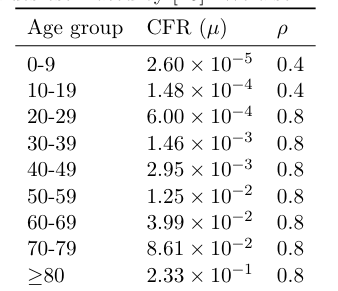


Node id's starting:               
*index_start['PID'] = 0
*index_start['NODE'] = 1000000
*index_start['HHID'] = 2000000
*index_start['BUSLINE_TRIPNUM'] = 3000000
*index_start['MRTLINE_TRIPNUM'] = 4000000
*index_start['WORK_NODE'] = 5000000
*index_start['EDUCATION_NODE'] = 6000000
*index_start['SHOPPING_NODE'] = 7000000
*index_start['OTHER_NODE'] = 8000000

In [134]:
###### process and count new infections
est_r_0 = []
# ! pip install sortednp
import sortednp as snp
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
master_start_time = time.time()
! mkdir running_statevectors

# 1: S
# 2: E
# 3: I_s
# 4: I_a
# 5: R
# 6: D

d_D_mu_sigma = {}
with open('age_wise_mu_and_sigma_for_D.csv') as f:
    next(f)
    for row in f:
        listed = row.strip().split(',')
        d_D_mu_sigma[int(listed[0])] = {'mu':float(listed[1]), 'sigma':float(listed[2])}

age_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:6, 13:6, 14:7, 15:7, 16:7, 17:7}
for initial_infections in [200]:
  
    st_dict = {} # keeping track of total stats
    
    stateVector = np.random.rand(len(pidDict),2) * 0 
    stateVector [:,1] = 0
    
    
    rho_binary = np.random.rand(len(pidDict),1) * 0  # binary values to decide whether the person is going to go to I_s or not
    count_missing_age = 0 
    count_missing_pt_areas = 0 
    for i in range(rho_binary.shape[0]):
        if i not in age:
            print ("Missing PID index in age dict ",i)
            continue
        
        age_ = age_map[age[i]]
        if age_ > 2:
            rho = 0.8
        else:
            rho = 0.4
        
        r = np.random.rand()
        if r < rho:
            rho_binary[i,0] = 1   # marked for progression to I_S


    # everyone is susceptible
    stateVector[:,:] = [1,0]
    n_X = initial_infections 
    
    for i in range(len(pidDict)):
        if np.random.rand() < initial_infections/len(pidDict):
            stateVector[i,:] = [4,0]
         
    startTime = time.time()
    nodes_for_plotting = []
    calibrated_theta_prime =  0.22 # after random fix # 0.25 # 0.07 


    backup_states = []
    pids_to_be_removed_from_population = set([])
    ilist = []

    infections_per_node = {}
    recoveries_per_node = {}    
    deaths_per_node = {}
    for ii in range(730):
        infections_per_node[ii] = {}
        recoveries_per_node[ii] = {}
        deaths_per_node[ii] = {}
        
    for day_num in range(275) : # days
        

        for t in range(0,288):  # 1 day   

            d = time.time()
            if load_graphs_in_RAM == False:
                with open('UNION_dicts/union_dict_'+str(t)+'.pickle', 'rb') as handle:
                    G = pickle.load(handle)
            G = G_loaded[t]
            
         
            numberOfInfectiousNeigboursTracker = {}   ## key:location   ## value count
            a = time.time()
            indices_of_infected = (np.where(stateVector[:,0] == 4)[0])
            for pid in indices_of_infected:
                if pid in pids_to_be_removed_from_population:
                    continue
                if pid not in G['forward']:
                    continue

                
                if G['forward'][pid] not in numberOfInfectiousNeigboursTracker :
                    numberOfInfectiousNeigboursTracker[G['forward'][pid]] = 1
                else:
                    numberOfInfectiousNeigboursTracker[G['forward'][pid]] += 1
            b = time.time()


            for dummy in G['backward']:
                if dummy not in numberOfInfectiousNeigboursTracker:
                    continue
                
                    
                if dummy < 20000000 or dummy >= 50000000:    ### NODE ACTIVITY 
                    assert(not(dummy>=50000000 and dummy<60000000 )) # should never happen
                    if dummy >= 60000000 and dummy < 70000000:  # WORK 
                        area_of_this_dummy = node_wise_A[dummy - index_start['WORK_NODE']]
                    elif dummy >= 70000000 and dummy < 80000000:  # EDUCATION :
                        area_of_this_dummy = node_wise_A[dummy - index_start['EDUCATION_NODE']]
                    elif dummy >= 80000000 and dummy < 90000000:  # SHOPPING :
                        area_of_this_dummy = node_wise_A[dummy - index_start['SHOPPING_NODE']]
                    elif dummy >= 90000000 and dummy < 100000000:  # OTHER :
                        area_of_this_dummy = node_wise_A[dummy - index_start['OTHER_NODE']]

                    if area_of_this_dummy > 39800000:
                        area_of_this_dummy = 39800000
                    sigma = area_of_this_dummy * 0.0572 # 0.00040941176 # 0.048 * 0.005
                    sigma_x = sigma
                    sigma_y = sigma
                    infectious_ppl = np.random.multivariate_normal([0,0], ([sigma_x,0],[0,sigma_y]), numberOfInfectiousNeigboursTracker[dummy])
                    p_n = np.random.multivariate_normal([0,0], ([sigma_x,0],[0,sigma_y]), 1)
                    d = np.sum((p_n - infectious_ppl)**2, axis = 1)
                    mean_dist = np.mean(d**0.5)  
                    ilist.append(mean_dist)
                    
                elif dummy >= 30000000 and dummy < 50000000:    ## PT 
                    if dummy < 40000000:  # BUS
                        L = 2.759 * (4**0.333) # (A_bus * 1/4) ** 0.5 
                    else: # MRT
                        L = 3.314 * (25 ** 0.333) # (A_mrt_coach * 1/5) ** 0.5  
                    mean_dist = L * 0.5014
                elif dummy < 30000000 and dummy >= 20000000:  ##HOME 
                    mean_dist = 6.5
                    
                summation_i_tau = 1/((mean_dist) ** 3) * numberOfInfectiousNeigboursTracker[dummy]
                Phi_n_t = 1 - np.exp( - calibrated_theta_prime * summation_i_tau)

                if numberOfInfectiousNeigboursTracker[dummy] > 0:
                    for pid in G['backward'][dummy]:        
                        if pid in pids_to_be_removed_from_population:
                            continue                        
                        if np.random.rand() < Phi_n_t and stateVector[pid,0] == 1:
                            stateVector[pid,0] = 2 
#                             if dummy < 20000000 or dummy >= 50000000: # only tracking the cases which occur during performing an activity
                            if dummy not in infections_per_node[day_num]:
                                infections_per_node[day_num][dummy] = 1
                            else:
                                infections_per_node[day_num][dummy] += 1
            c = time.time()
            
#             print (t, a-d, b-a, c-b, " seconds " )

        # getting total stats from state vector
        st_dict['S',day_num+1] = len(np.where(stateVector[:,0] == 1)[0])
        st_dict['E',day_num+1]  = len(np.where(stateVector[:,0] == 2)[0])
        st_dict['I_s',day_num+1]  = len(np.where(stateVector[:,0] == 3)[0])
        st_dict['I_a',day_num+1]  = len(np.where(stateVector[:,0] == 4)[0])
        st_dict['R',day_num+1]  = len(np.where(stateVector[:,0] == 5)[0])
        st_dict['D',day_num+1]  = len(np.where(stateVector[:,0] == 6)[0])

        ll = []
        for ii in range(len(ilist)):
            if ilist[ii] < 200:
                ll.append(ilist[ii])
#         plt.hist(ll, 100)
#         plt.show()
        
        backup_states.append(np.array(stateVector))
        for i in range(stateVector.shape[0]): 
            # I_s -> R or I_a -> R
            if stateVector[i,0] == 3 or stateVector[i,0] == 4 :
                d_I = np.random.lognormal(1.96, 0.42 ** 0.5, 1)   # mu = 1.62; sigma_square = 0.42
                Y_n_d = 1 - np.exp(-1/d_I)
                if np.random.rand() < Y_n_d:
                    stateVector[i,0] = 5   
                    hhid_ = hhid[i]
                    if hhid_ not in recoveries_per_node[day_num]:
                        recoveries_per_node[day_num][hhid_] = 1
                    else:
                        recoveries_per_node[day_num][hhid_] += 1                    
                    
        ### actual updates of states
        for i in range(stateVector.shape[0]):
        # I_s -> D 
            if stateVector[i,0] == 3 :
                age_ = age_map[age[i]]
                d_D =  np.random.lognormal(d_D_mu_sigma[age_]['mu'], d_D_mu_sigma[age_]['sigma'], 1)   # average of 30 days of hospitalisation before death
                Mu_n_d = 1 - np.exp(-1/d_D)
                xx = np.random.rand()

                if xx < Mu_n_d:
                    stateVector[i,0] = 6   
                    hhid_ = hhid[i]
                    if hhid_ not in deaths_per_node[day_num]:
                        deaths_per_node[day_num][hhid_] = 1
                    else:
                        deaths_per_node[day_num][hhid_] += 1
                        
        # E -> I_a
        for i in range(stateVector.shape[0]): 
            if rho_binary[i] != 1:   # good news
                if stateVector[i,0] == 2 :
                    d_L = np.random.lognormal(1.62, 0.42 ** 0.5, 1)   # mu = 1.62; sigma_square = 0.42
                    K_n_d = 1 - np.exp(-1/d_L)
                    if np.random.rand() < K_n_d:
                        stateVector[i,0] = 4                    
        
        for i in range(stateVector.shape[0]):      
            # E -> I_s
            if rho_binary[i] == 1:  # bad news
                if stateVector[i,0] == 2 :
                    d_L = np.random.lognormal(1.62, 0.42 ** 0.5, 1)   # mu = 1.62; sigma_square = 0.42
                    K_n_d = 1 - np.exp(-1/d_L)
                    if np.random.rand() < K_n_d:
                        stateVector[i,0] = 3
                        pids_to_be_removed_from_population.add(i)
        
        with open('running_statevectors/stateVector_at_day'+str(day_num)+'.pickle', 'wb') as handle:
            pickle.dump(stateVector, handle, protocol=pickle.HIGHEST_PROTOCOL) 
            
        with open('running_statevectors/infections_per_node_day'+str(day_num)+'.pickle', 'wb') as handle:
            pickle.dump(infections_per_node, handle, protocol=pickle.HIGHEST_PROTOCOL)           
                        
        print ("Count of missing age: ", count_missing_age)
        print ("Count ``of missing PT area: ", count_missing_pt_areas)        
        print ("S: " , st_dict['S',day_num+1], "E: ", st_dict['E',day_num+1], "I_s: ",st_dict['I_s',day_num+1], "I_a: ", st_dict['I_a',day_num+1], "R: ",st_dict['R',day_num+1], "D: ", st_dict['D',day_num+1])                                         
        print ("At the end of Day ", day_num+1,  time.time() - master_start_time, '\n\n\n\n\n\n')


mkdir: cannot create directory ‘running_statevectors’: File exists
Count of missing age:  0
Count ``of missing PT area:  0
S:  2407 E:  66 I_s:  0 I_a:  201 R:  0 D:  0
At the end of Day  1 1.9770138263702393 






Count of missing age:  0
Count ``of missing PT area:  0
S:  2365 E:  97 I_s:  6 I_a:  172 R:  34 D:  0
At the end of Day  2 3.4879536628723145 






Count of missing age:  0
Count ``of missing PT area:  0
S:  2326 E:  114 I_s:  15 I_a:  143 R:  76 D:  0
At the end of Day  3 4.808301687240601 






Count of missing age:  0
Count ``of missing PT area:  0
S:  2300 E:  114 I_s:  33 I_a:  134 R:  93 D:  0
At the end of Day  4 6.100288152694702 






Count of missing age:  0
Count ``of missing PT area:  0
S:  2281 E:  103 I_s:  47 I_a:  117 R:  126 D:  0
At the end of Day  5 7.183269739151001 






Count of missing age:  0
Count ``of missing PT area:  0
S:  2270 E:  98 I_s:  50 I_a:  106 R:  150 D:  0
At the end of Day  6 8.188786506652832 






Count of missing age:  0
Coun

In [135]:
# G_loaded = {}
# import gc
# gc.collect()

In [136]:
with open('overall_state_theta.pickle', 'wb') as handle:
    pickle.dump(backup_states, handle, protocol=pickle.HIGHEST_PROTOCOL) 
with open('infections_per_node.pickle', 'wb') as handle:
    pickle.dump(infections_per_node, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('deaths_per_node.pickle', 'wb') as handle:
    pickle.dump(deaths_per_node, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [137]:
import pickle
backup_states_loaded = {}
path_for_backup_file = 'running_statevectors'
!mkdir running_statevectors
for i in range(275):
    with open(path_for_backup_file+'/stateVector_at_day'+str(i)+'.pickle','rb') as handle:
        backup_states_loaded[i] = pickle.load(handle)     

mkdir: cannot create directory ‘running_statevectors’: File exists


In [138]:
# import pickle
# path_for_backup_file = 'running_statevectors'
# with open(path_for_backup_file+'/age_at_day'+str(i)+'.pickle','rb') as handle:
#     age = pickle.load(handle)     

In [139]:
# path_for_backup_file = 'RUNS_MAY_28_FINAL'
# with open(path_for_backup_file+'/infections_per_node_day274.pickle', 'rb') as handle:
#     infections_per_node = pickle.load(handle)

In [140]:
import pickle
path_for_backup_file = '.'
with open(path_for_backup_file+'/overall_state_theta.pickle','rb') as handle:
    backup_states_loaded = pickle.load(handle) 
with open(path_for_backup_file+'/infections_per_node.pickle', 'rb') as handle:
    infections_per_node = pickle.load(handle)
with open(path_for_backup_file+'/deaths_per_node.pickle', 'rb') as handle:
    deaths_per_node = pickle.load(handle)

AI_E_plus_I_sim= [267, 275, 272, 281, 267, 254, 251, 245, 226, 207, 192, 163, 144, 129, 117, 104, 89, 80, 73, 67, 58, 52, 49, 45, 40, 36, 30, 29, 24, 17, 11, 10, 9, 8, 6, 5, 5, 4, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
AI_D_sim= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

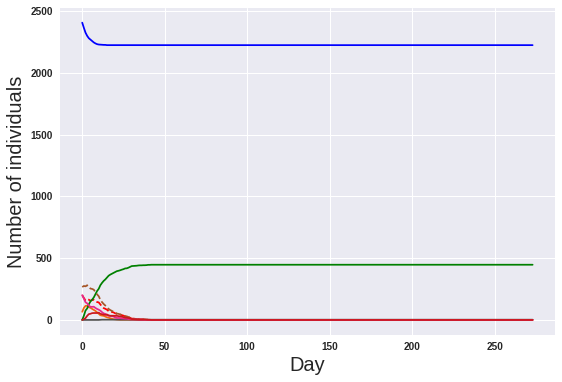

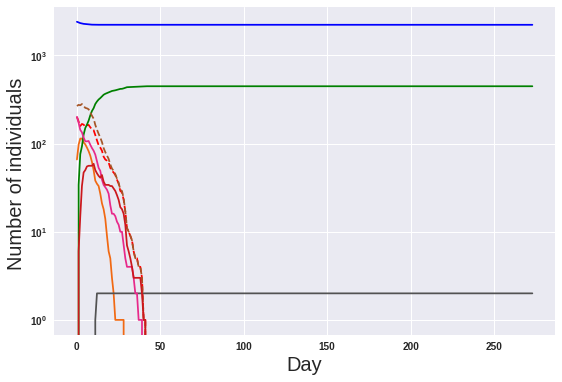

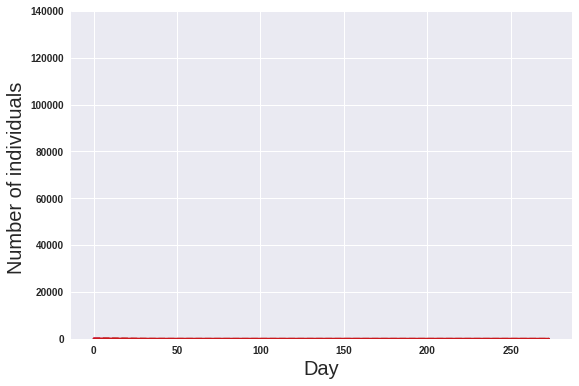

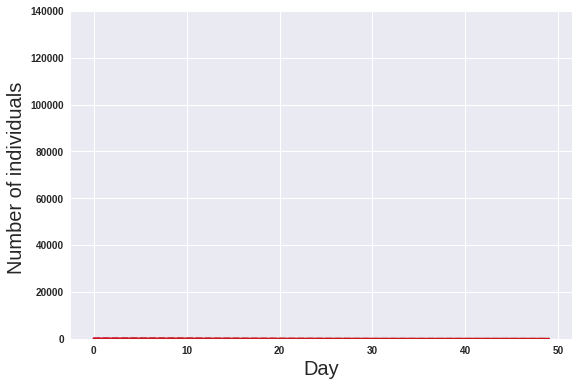

In [141]:
import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import numpy as np
# mpl.style.use('seaborn')
# mpl.rc_file_defaults()
# backup_states_loaded = backup_states

font = {'weight' : 'bold',
        'size'   : 13}

mpl.rc('font', **font)

S = []
E = []
I = []
R = []
D = []
I_a = []
E_plus_I = []
I_s = []
for i in range(1,275):
    stateVector = backup_states_loaded[i-1]
    S.append(len(np.where(stateVector[:,0] == 1)[0]))
    E.append(len(np.where(stateVector[:,0] == 2)[0]))
    I.append(len(np.where(stateVector[:,0] == 3)[0]) + len(np.where(stateVector[:,0] == 4)[0]))
    R.append(len(np.where(stateVector[:,0] == 5)[0]))
    D.append(len(np.where(stateVector[:,0] == 6)[0]))
    I_a.append(len(np.where(stateVector[:,0] == 4)[0]))
    I_s.append(len(np.where(stateVector[:,0] == 3)[0]))
    E_plus_I.append(I[-1] + E[-1])

plt.plot(range(len(S)), S,'b', label='S')
plt.plot(range(len(E)), E,'#F16913', label='E')
plt.plot(range(len(I)), I,color='red',linestyle='--', label='I = '+r'$ I^S$' + r'+$ I^A$')
plt.plot(range(len(R)), R,'green', label='R')
plt.plot(range(len(D)), D,'#525252', label='D')
plt.plot(range(len(E_plus_I)), E_plus_I,'--',color='#a65628', label='E + I')
print ('AI_E_plus_I_sim=', E_plus_I)
print ('AI_D_sim=', D)
plt.plot(range(len(I_a)), I_a,color='#E7298A', label=r'$ I^A$')
plt.plot(range(len(I_s)), I_s,color='#CB181D',label=r'$ I^S$')


plt.yscale('linear')
plt.xlabel("Day", fontsize=20)
plt.ylabel("Number of individuals", fontsize=20)
# plt.legend(loc = 'best')
plt.tight_layout()

# plt.grid()

plt.savefig("overall_state_theta_SEIR.png", dpi=600)
plt.show()



plt.plot(range(len(S)), S,'b', label='S')
plt.plot(range(len(E)), E,'#F16913', label='E')
plt.plot(range(len(I)), I,color='red', linestyle='--',label='I = '+r'$ I^S$' + r'+$ I^A$')
plt.plot(range(len(R)), R,'green', label='R')
plt.plot(range(len(D)), D,color='#525252', label='D')
plt.plot(range(len(E_plus_I)), E_plus_I,'--',color='#a65628', label='E + I')
plt.plot(range(len(I_a)), I_a, color='#E7298A',label=r'$ I^A$')
plt.plot(range(len(I_s)), I_s, color='#CB181D', label=r'$ I^S$')
plt.yscale('log')
# plt.grid()

plt.xlabel("Day", fontsize=20)
plt.ylabel("Number of individuals ", fontsize=20)
# plt.legend(loc = 'upper right', fontsize=8)
plt.tight_layout()

plt.savefig("overall_state_theta_SEIR_log_scale.png", dpi=600)

plt.show()



# plt.plot(range(len(S)), S,'b', label='S')
plt.plot(range(len(E)), E,'#F16913', label='E')
plt.plot(range(len(I)), I,color='red',linestyle='--', label='I = '+r'$ I^S$' + r'+$ I^A$')
# plt.plot(range(len(R)), R,'green', label='R')
plt.plot(range(len(D)), D,color='#525252', label='D')
plt.plot(range(len(E_plus_I)), E_plus_I,'--',color='#a65628', label='E + I')
plt.plot(range(len(I_a)), I_a,color='#E7298A', label=r'$ I^A$')
plt.plot(range(len(I_s)), I_s,color='#CB181D', label=r'$ I^S$')

plt.yscale('linear')
plt.xlabel("Day",fontsize=20)
plt.ylabel("Number of individuals ",fontsize=20)
# plt.legend(loc = 'best')
plt.tight_layout()
plt.ylim(0,140000)
# plt.grid()

plt.savefig("overall_state_theta_SEIR_S_R_removed.png", dpi=600)

plt.show()




# plt.plot(range(len(S)), S,'b', label='S')
plt.plot(range(50), E[:50],'#F16913', label='E')
plt.plot(range(50), I[:50],color='red',linestyle='--', label='I = '+r'$I^S$' + r'+$I^A$')
# plt.plot(range(len(R)), R,'green', label='R')
plt.plot(range(50), D[:50],color='#525252', label='D')
plt.plot(range(50), E_plus_I[:50],'--',color='#a65628', label='E + I')
plt.plot(range(50), I_a[:50],color='#E7298A', label=r'$ I^A$')
plt.plot(range(50), I_s[:50],color='#CB181D', label=r'$ I^S$')

# plt.grid()
plt.yscale('linear')
plt.xlabel("Day",fontsize=20)
plt.ylabel("Number of individuals ", fontsize=20)
# plt.legend(loc = 'best')
plt.tight_layout()
plt.ylim(0,140000)
plt.savefig("overall_state_theta_SEIR_S_R_removed_zoomed_towards_outbreak.png", dpi=600)

plt.show()




In [142]:
print (len(backup_states_loaded))

275


In [143]:
! pip install altair
age_labels = {'0':'0-9', '1':'10-19','2':'20-29 ','3':'30-39','4':'40-49','5':'50-59','6':'60-69','7':'>70'}
age_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:6, 13:6, 14:7, 15:7, 16:7, 17:7}

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import numpy as np
mpl.style.use('seaborn')


age_count_percentage = {}
for j in range(len(backup_states_loaded[0])):
    age_ = age_map[age[j]]
    if age_ in age_count_percentage:
        age_count_percentage [age_] += 1
    else:
        age_count_percentage [age_] = 1
for key in range(8):
    print (key, round(age_count_percentage[key]*100/sum(age_count_percentage.values()),2),'%')
 
agewise = np.random.rand(4,4,8) * 0   # 4 days;  # 5 for E/Ia/Is/D; # 8 age categories

count = 0
weekrange = range(32,36)
for t in weekrange:
    day_ = t*7+ 1
    stateVector = backup_states_loaded[day_-1]
    stateVectorPrev = backup_states_loaded[day_-1]

  
    for j in range(stateVector.shape[0]):
        age_ = age_map[age[j]]
        state = stateVector[j][0]
        if state == 2:
            agewise[count,0,age_] += 1   # E
        if state == 4:
            agewise[count,1,age_] += 1   # I a
        if state == 3:
            agewise[count,2,age_] += 1   # I s 
        if state == 6:
            agewise[count,3,age_] += 1   # D         
    count += 1
    
    
print (np.sum(agewise))
import pandas as pd
import numpy as np
import altair as alt
age_Cat_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','>70']

indexList = []
for i in weekrange:
    indexList.append('Week '+str(i+1))

dflist = []
for i in range(8):
    dflist.append(pd.DataFrame(agewise[:,:,i],index=indexList,columns=['E','I a','I s','D']))


def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns =  ['c1', 'c2', 'values']
    df['Age category'] = name
    return df

for i in range(8):
    dflist[i] = prep_df(dflist[i], age_Cat_labels[i] + ' years' )


df = pd.concat(dflist)

alt.Chart(df).mark_bar().encode(
    x=alt.X('c2:N', title=None),
    y=alt.Y('sum(values):Q', axis=alt.Axis(grid=False, title=None)),
    column=alt.Column('c1:N', title=None),
    color=alt.Color('Age category:N', scale=alt.Scale(range=list((['#f7f4f9','#e7e1ef','#d4b9da','#c994c7','#df65b0','#e7298a','#ce1256','#91003f']))))
).configure_view(
    strokeOpacity=0    
)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/mnt/anaconda3/bin/python -m pip install --upgrade pip' command.
0 11.89 %
1 13.24 %
2 15.07 %
3 12.64 %
4 13.54 %
5 14.4 %
6 10.25 %
7 8.98 %
8.0


alt.Chart(...)

In [144]:
count = 0 
for key in pidDict :
    print (key, pidDict[key], age[pidDict[key]])
    count += 1
    if count > 10:
        break

3088633-1 0 5
2167697-1 1 6
378028-1 2 11
715589-1 3 12
2182595-1 4 1
749547-1 5 8
115927-1 6 6
1209532-1 7 8
1406369-1 8 16
1175156-1 9 14
37238-1 10 5


In [145]:
# normalising all EIRD so that the bars are of equal length
# for i in range(5):
#     for day in range(4):
#         agewise[day,i,:] = agewise[day,i,:]*100/(np.sum(agewise[day,i,:]))
# backup_states_loaded

In [146]:
agewise[:,-1,:]

array([[0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 1.]])

In [147]:
!tar -czvf stacked.tar.gz stacked

tar: stacked: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [148]:

#### R_t

S = []
E = []
I = []
R = []
D = []
I_a = []
E_plus_I = []
I_s = []
r_t = []
Inf_rate = []
Death_rate = []
stateVector = backup_states_loaded[0]
# r_t = [(len(np.where(stateVector[:,0] == 2)[0]))/(len(np.where(stateVector_prev[:,0] == 4)[0]))]  #  initial infections. Important, since the infection dies out very fast in case of no PT
# the smoothing of the curve removes this; hence putting this manually

for i in range(2,275):
    stateVector = backup_states_loaded[i-1]
    stateVector_prev = backup_states_loaded[i-2]
    
    denominator = (len(np.where(stateVector_prev[:,0] == 4)[0]))
    
   
    count = 0 
    for j in range(stateVector.shape[0]):
        if stateVector[j][0] == 2 and stateVector_prev[j][0] == 1:
            count += 1
    numerator = count
    if denominator != 0 :
        r_t.append(numerator/denominator)
    else:
        r_t.append(0)
    
    
    Inf_rate.append(numerator)
    
    
    new_deaths_today = len(np.where(stateVector[:,0] == 6)[0]) -  len(np.where(stateVector_prev[:,0] == 6)[0])
    Death_rate.append(new_deaths_today)
    


# plt.plot(range(len(r_t)), r_t,'--', label='R_t')


In [149]:
# count = 0
# for i in range(1,10):
#     stateVector = backup_states_loaded[i]  
# #     for j in range(stateVector.shape[0]):
# #         if stateVector[j][0] == 2 and backup_states_loaded[i-1][j][0] == 1:
# #             count += 1
# #     print (count, 191, count/191*100)
#     print ((len(np.where(stateVector[:,0] == 2)[0])), (len(np.where(stateVector[:,0] == 4)[0])))

In [150]:
r_t_backup = list(r_t)

In [151]:
r_t = list(r_t_backup)

R_t_no_transit :  [0.208955223880597, 0.22674418604651161, 0.18181818181818182, 0.1417910447761194, 0.09401709401709402, 0.10377358490566038, 0.11320754716981132, 0.07476635514018691, 0.061855670103092786, 0.033707865168539325, 0.012048192771084338, 0.013333333333333334, 0.015873015873015872, 0.0, 0.04081632653061224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

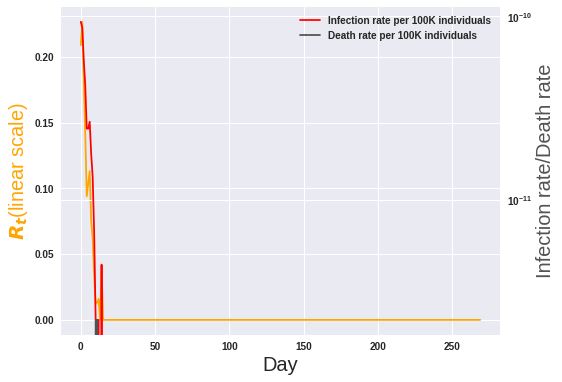

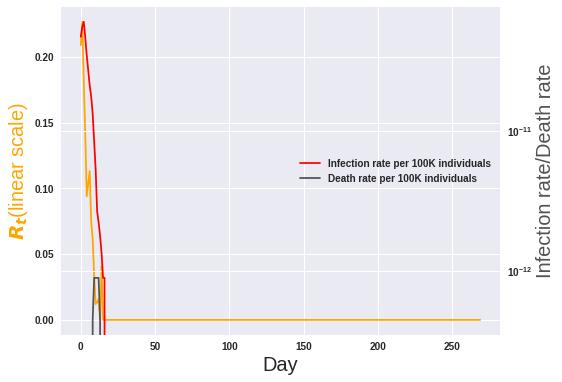

In [152]:
font = {'weight' : 'bold',
        'size'   : 13}

mpl.rc('font', **font)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
# r_t_sm = np.convolve(r_t, np.ones((5,))/5, mode='same')
# Death_rate_sm = np.convolve(Death_rate, np.ones((5,))/5, mode='same')
# Inf_rate_sm = np.convolve(Inf_rate, np.ones((5,))/5, mode='same')
print ("R_t_no_transit : ", r_t)
print ("Death_rate_no_transit : ", Death_rate)
print ("Infection_rate_no_transit : ", Inf_rate)

r_t_sm = np.convolve(r_t, np.ones((1,))/1, mode='same')
Death_rate_sm = np.convolve(Death_rate, np.ones((1,))/1, mode='same')
Inf_rate_sm = np.convolve(Inf_rate, np.ones((1,))/1, mode='same')



Death_rate_sm /= (4500000*100000)
Inf_rate_sm/= (4500000*100000)

ax1.plot(range((270)), r_t_sm[:270],'orange', label='R(t)')
ax2.plot(range((270)), Inf_rate_sm[:270], 'red', label = 'Infection rate per 100K individuals')
ax2.plot(range((270)), Death_rate_sm[:270], '#525252', label = 'Death rate per 100K individuals')

ax2.set_yscale('log')


ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel(r'$R_t$(linear scale)', color='orange', fontsize=20)
ax2.set_ylabel('Infection rate/Death rate', fontsize=20, color='#525252')
plt.tight_layout()
plt.legend(loc='best', fontsize=10)
# plt.grid()
plt.savefig('R_t.png',dpi=600)
plt.show()

# ax2.set_ylabel('Y2 data', color='b')

############################# smoothed 
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
r_t_sm = np.convolve(r_t, np.ones((5,))/5, mode='same')
Death_rate_sm = np.convolve(Death_rate, np.ones((5,))/5, mode='same')
Inf_rate_sm = np.convolve(Inf_rate, np.ones((5,))/5, mode='same')


# r_t_sm = np.convolve(r_t, np.ones((1,))/1, mode='same')
# Death_rate_sm = np.convolve(Death_rate, np.ones((1,))/1, mode='same')
# Inf_rate_sm = np.convolve(Inf_rate, np.ones((1,))/1, mode='same')

r_t_sm[:30] = r_t[:30]

Death_rate_sm /= (4500000*100000)
Inf_rate_sm/= (4500000*100000)

ax1.plot(range((270)), r_t_sm[:270],'orange', label='R(t)')
ax2.plot(range((270)), Inf_rate_sm[:270], 'red', label = 'Infection rate per 100K individuals')
ax2.plot(range((270)), Death_rate_sm[:270], '#525252', label = 'Death rate per 100K individuals')

ax2.set_yscale('log')

ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel(r'$R_t$(linear scale)', color='orange', fontsize=20)
ax2.set_ylabel('Infection rate/Death rate', fontsize=20, color='#525252')
plt.legend(loc='center right', fontsize=10)
# plt.grid()

plt.tight_layout()
plt.savefig('R_t smoothed.png',dpi=600)
plt.show()

# ax2.set_ylabel('Y2 data', color='b')


In [153]:
import csv
with open('NO_PT_AI_Rt.csv' ,'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(['R_t','Inf_rate','Death_rate'])
    for i in range(273):
        csvwriter.writerow([r_t_sm[i], Inf_rate_sm[i], Death_rate_sm[i]])



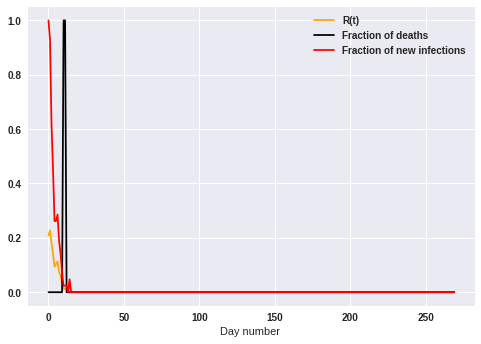

In [154]:


plt.xlabel("Day number ")
# plt.plot()
# plt.plot()
# plt.plot()

max_deathrate = max(Death_rate)
Death_rate_fraction = []
for i in range(len(Death_rate)):
    Death_rate_fraction.append(Death_rate[i]/max_deathrate)
    
max_Infrate = max(Inf_rate)
Inf_rate_fraction = []
for i in range(len(Inf_rate)):
    Inf_rate_fraction.append(Inf_rate[i]/max_Infrate)

plt.plot(range((270)), r_t[:270],'orange', label='R(t)')
plt.plot(range((270)), Death_rate_fraction[:270], 'black', label = 'Fraction of deaths')
plt.plot(range((270)), Inf_rate_fraction[:270], 'red', label = 'Fraction of new infections')
plt.legend(loc = 'best')
plt.savefig("R(t) .png", dpi=600)
plt.show()



In [155]:
r_t_backup = list(r_t)

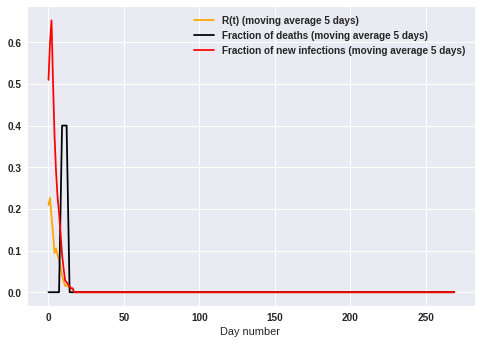

In [156]:
# plt.plot(range(len(r_t)), r_t,'orange', label='R_t')


r_tt = np.convolve(r_t_backup, np.ones((5,))/5, mode='same')
r_tt[:5] = r_t_backup[:5]
plt.xlabel("Day number ")
# plt.plot()
# plt.plot()
# plt.plot()

max_deathrate = max(Death_rate)
Death_rate_fraction = []
for i in range(len(Death_rate)):
    Death_rate_fraction.append(Death_rate[i]/max_deathrate)
Death_rate_fraction = np.convolve(Death_rate_fraction, np.ones((5,))/5, mode='same')

max_Infrate = max(Inf_rate)
Inf_rate_fraction = []
for i in range(len(Inf_rate)):
    Inf_rate_fraction.append(Inf_rate[i]/max_Infrate)
Inf_rate_fraction = np.convolve(Inf_rate_fraction, np.ones((5,))/5, mode='same')
    

plt.plot(range((270)), r_tt[:270],'orange', label='R(t) (moving average 5 days)')
plt.plot(range((270)), Death_rate_fraction[:270], 'black', label = 'Fraction of deaths (moving average 5 days)')
plt.plot(range((270)), Inf_rate_fraction[:270], 'red', label = 'Fraction of new infections (moving average 5 days)')
plt.legend(loc = 'best')
plt.savefig("R(t) moving average of 5 days.png", dpi=600)
plt.show()





In [157]:
import matplotlib
# Clear the current axes.
plt.cla() 
# Clear the current figure.
plt.clf() 
# Closes all the figure windows.
plt.close('all')
import gc
gc.collect()

17616

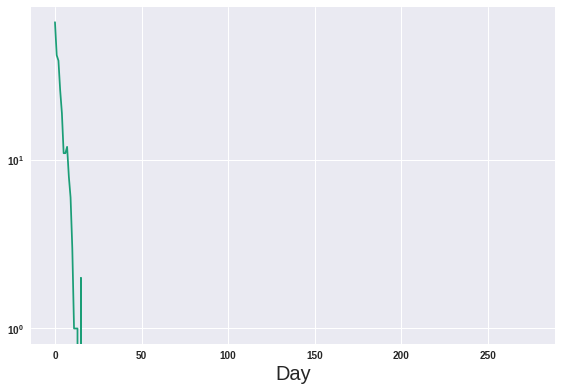

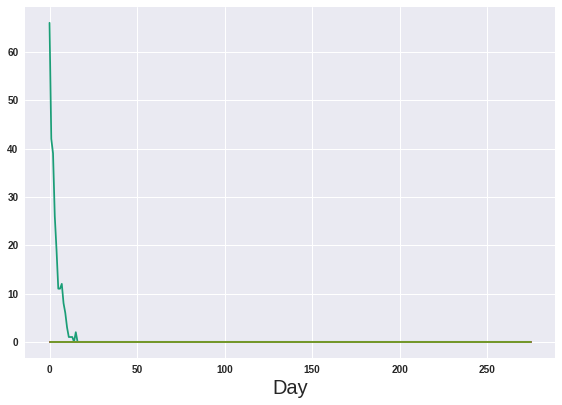

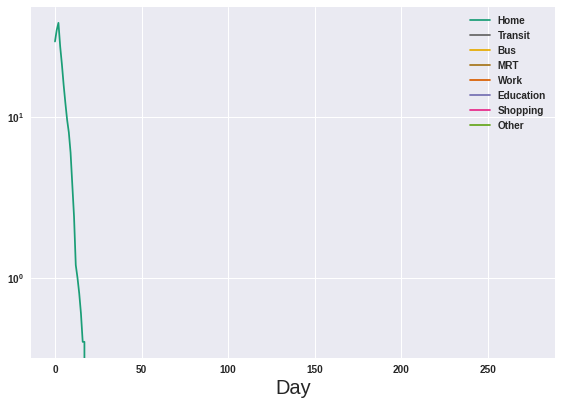

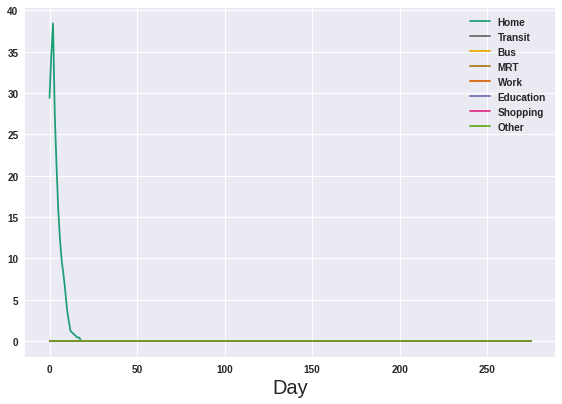

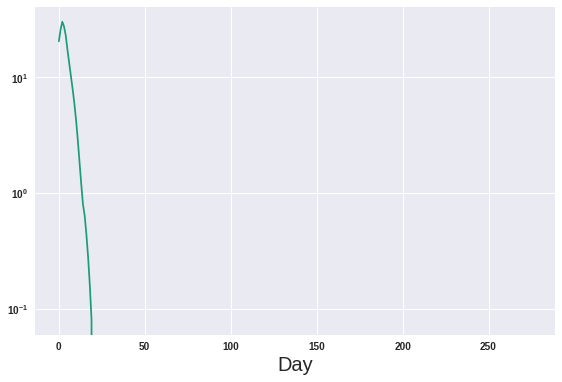

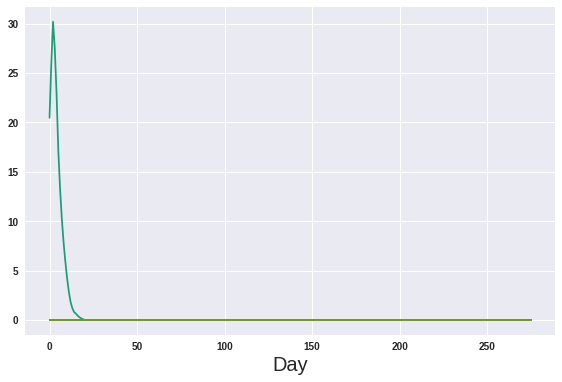

In [158]:
### daily transmission by activity
#  dummy < 20000000 or dummy >= 50000000:    ### NODE ACTIVITY 
#  dummy >= 60000000 and dummy < 70000000:  # WORK 
#  dummy >= 70000000 and dummy < 80000000:  # EDUCATION :
#  dummy >= 80000000 and dummy < 90000000:  # SHOPPING :
#  dummy >= 90000000 and dummy < 100000000:  # OTHER :
#  dummy >= 30000000 and dummy < 50000000:    ## PT 
#         dummy < 40000000:  # BUS
#                     else: # MRT
#  dummy < 30000000 and dummy >= 20000000:  ##HOME 
n = 276
infections_at_work = [0] * n
infections_at_school = [0] * n 
infections_at_shopping = [0] * n
infections_at_other = [0] * n
infections_at_PT = [0] * n
infections_at_BUS = [0] * n
infections_at_MRT = [0] * n
infections_at_Home = [0] * n
for i in range(n):
    for dummy in infections_per_node[i]:
        if dummy >= 60000000 and dummy < 70000000: # WORK
            infections_at_work[i] += (infections_per_node[i][dummy])
        if dummy >= 70000000 and dummy < 80000000: # EDUCATION
            infections_at_school[i] += (infections_per_node[i][dummy])
        if dummy >= 80000000 and dummy < 90000000: # SHOPPING
            infections_at_shopping[i] += (infections_per_node[i][dummy])
        if dummy >= 90000000 and dummy < 100000000:  # OTHER :
            infections_at_other[i] += (infections_per_node[i][dummy])      
        if dummy >= 30000000 and dummy < 50000000: # PT
            infections_at_PT[i] += (infections_per_node[i][dummy])      
            if dummy < 40000000: 
                infections_at_BUS[i] += (infections_per_node[i][dummy])      
            else:
                infections_at_MRT[i] += (infections_per_node[i][dummy])   
        if dummy < 30000000 and dummy >= 20000000:  ##HOME 
            infections_at_Home[i] += (infections_per_node[i][dummy])  
colormap = {'H':'#1b9e77','W':'#d95f02','E':'#7570b3','S':'#e7298a','O':'#66a61e','B':'#e6ab02','M':'#a6761d','Bus+MRT':'#666666'}
plt.plot(range(len(infections_at_Home)), infections_at_Home, label='Home',c=colormap['H'])
plt.plot(range(len(infections_at_PT)), infections_at_PT, label='Transit',c=colormap['Bus+MRT'])
plt.plot(range(len(infections_at_BUS)), infections_at_BUS, label='Bus',c=colormap['B'])
plt.plot(range(len(infections_at_MRT)), infections_at_MRT, label='MRT',c=colormap['M'])
plt.plot(range(len(infections_at_work)), infections_at_work, label='Work',c=colormap['W'])        
plt.plot(range(len(infections_at_school)), infections_at_school, label='Education',c=colormap['E'])
plt.plot(range(len(infections_at_shopping)), infections_at_shopping, label='Shopping',c=colormap['S'])
plt.plot(range(len(infections_at_other)), infections_at_other, label='Other',c=colormap['O'])
plt.yscale('log')
plt.xlabel('Day')
plt.tight_layout()
plt.xlabel('Day', fontsize=20)
plt.savefig('activity_wise_infections_logscale.png',dpi=600)
plt.show()

plt.plot(range(len(infections_at_Home)), infections_at_Home, label='Home',c=colormap['H'])
plt.plot(range(len(infections_at_PT)), infections_at_PT, label='Transit',c=colormap['Bus+MRT'])
plt.plot(range(len(infections_at_BUS)), infections_at_BUS, label='Bus',c=colormap['B'])
plt.plot(range(len(infections_at_MRT)), infections_at_MRT, label='MRT',c=colormap['M'])
plt.plot(range(len(infections_at_work)), infections_at_work, label='Work',c=colormap['W'])        
plt.plot(range(len(infections_at_school)), infections_at_school, label='Education',c=colormap['E'])
plt.plot(range(len(infections_at_shopping)), infections_at_shopping, label='Shopping',c=colormap['S'])
plt.plot(range(len(infections_at_other)), infections_at_other, label='Other',c=colormap['O'])

plt.tight_layout()
plt.xlabel('Day')
plt.xlabel('Day', fontsize=20)
plt.savefig('activity_wise_infections_linear_scale.png',dpi=600)
plt.show()


infections_at_Home = np.convolve(infections_at_Home, np.ones((5,))/5, mode='same')
infections_at_PT = np.convolve(infections_at_PT, np.ones((5,))/5, mode='same')
infections_at_BUS = np.convolve(infections_at_BUS, np.ones((5,))/5, mode='same')
infections_at_MRT = np.convolve(infections_at_MRT, np.ones((5,))/5, mode='same')
infections_at_work = np.convolve(infections_at_work, np.ones((5,))/5, mode='same')
infections_at_school = np.convolve(infections_at_school, np.ones((5,))/5, mode='same')
infections_at_shopping = np.convolve(infections_at_shopping, np.ones((5,))/5, mode='same')
infections_at_other = np.convolve(infections_at_other, np.ones((5,))/5, mode='same')

plt.plot(range(len(infections_at_Home)), infections_at_Home, label='Home',c=colormap['H'])
plt.plot(range(len(infections_at_PT)), infections_at_PT, label='Transit',c=colormap['Bus+MRT'])
plt.plot(range(len(infections_at_BUS)), infections_at_BUS, label='Bus',c=colormap['B'])
plt.plot(range(len(infections_at_MRT)), infections_at_MRT, label='MRT',c=colormap['M'])
plt.plot(range(len(infections_at_work)), infections_at_work, label='Work',c=colormap['W'])        
plt.plot(range(len(infections_at_school)), infections_at_school, label='Education',c=colormap['E'])
plt.plot(range(len(infections_at_shopping)), infections_at_shopping, label='Shopping',c=colormap['S'])
plt.plot(range(len(infections_at_other)), infections_at_other, label='Other',c=colormap['O'])
plt.yscale('log')
plt.legend(fontsize=10)
plt.tight_layout()
plt.xlabel('Day', fontsize=20)
plt.savefig('activity_wise_infections_logscale_smoothed.png',dpi=600)
plt.show()


plt.plot(range(len(infections_at_Home)), infections_at_Home, label='Home',c=colormap['H'])
plt.plot(range(len(infections_at_PT)), infections_at_PT, label='Transit',c=colormap['Bus+MRT'])
plt.plot(range(len(infections_at_BUS)), infections_at_BUS, label='Bus',c=colormap['B'])
plt.plot(range(len(infections_at_MRT)), infections_at_MRT, label='MRT',c=colormap['M'])
plt.plot(range(len(infections_at_work)), infections_at_work, label='Work',c=colormap['W'])        
plt.plot(range(len(infections_at_school)), infections_at_school, label='Education',c=colormap['E'])
plt.plot(range(len(infections_at_shopping)), infections_at_shopping, label='Shopping',c=colormap['S'])
plt.plot(range(len(infections_at_other)), infections_at_other, label='Other',c=colormap['O'])
plt.legend(fontsize=10)
plt.tight_layout()
plt.xlabel('Day', fontsize=20)
plt.savefig('activity_wise_infections_linear_scale_smoothed.png',dpi=600)
plt.show()

#### double smoothing
infections_at_Home = np.convolve(infections_at_Home, np.ones((5,))/5, mode='same')
infections_at_PT = np.convolve(infections_at_PT, np.ones((5,))/5, mode='same')
infections_at_BUS = np.convolve(infections_at_BUS, np.ones((5,))/5, mode='same')
infections_at_MRT = np.convolve(infections_at_MRT, np.ones((5,))/5, mode='same')
infections_at_work = np.convolve(infections_at_work, np.ones((5,))/5, mode='same')
infections_at_school = np.convolve(infections_at_school, np.ones((5,))/5, mode='same')
infections_at_shopping = np.convolve(infections_at_shopping, np.ones((5,))/5, mode='same')
infections_at_other = np.convolve(infections_at_other, np.ones((5,))/5, mode='same')

plt.plot(range(len(infections_at_Home)), infections_at_Home, label='Home',c=colormap['H'])
plt.plot(range(len(infections_at_PT)), infections_at_PT, label='Transit',c=colormap['Bus+MRT'])
plt.plot(range(len(infections_at_BUS)), infections_at_BUS, label='Bus',c=colormap['B'])
plt.plot(range(len(infections_at_MRT)), infections_at_MRT, label='MRT',c=colormap['M'])
plt.plot(range(len(infections_at_work)), infections_at_work, label='Work',c=colormap['W'])        
plt.plot(range(len(infections_at_school)), infections_at_school, label='Education',c=colormap['E'])
plt.plot(range(len(infections_at_shopping)), infections_at_shopping, label='Shopping',c=colormap['S'])
plt.plot(range(len(infections_at_other)), infections_at_other, label='Other',c=colormap['O'])
plt.yscale('log')
plt.xlabel('Day', fontsize=20)
# plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('activity_wise_infections_logscale_double_smoothed.png',dpi=600)
plt.show()


plt.plot(range(len(infections_at_Home)), infections_at_Home, label='Home',c=colormap['H'])
plt.plot(range(len(infections_at_PT)), infections_at_PT, label='Transit',c=colormap['Bus+MRT'])
plt.plot(range(len(infections_at_BUS)), infections_at_BUS, label='Bus',c=colormap['B'])
plt.plot(range(len(infections_at_MRT)), infections_at_MRT, label='MRT',c=colormap['M'])
plt.plot(range(len(infections_at_work)), infections_at_work, label='Work',c=colormap['W'])        
plt.plot(range(len(infections_at_school)), infections_at_school, label='Education',c=colormap['E'])
plt.plot(range(len(infections_at_shopping)), infections_at_shopping, label='Shopping',c=colormap['S'])
plt.plot(range(len(infections_at_other)), infections_at_other, label='Other',c=colormap['O'])
# plt.legend(fontsize=20)
plt.xlabel('Day', fontsize=20)
plt.tight_layout()
plt.savefig('activity_wise_infections_linear_scale_double_smoothed.png',dpi=600)
plt.show()


In [159]:



age_labels = {'0':'0-9', '1':'10-19','2':'20-29 ','3':'30-39','4':'40-49','5':'50-59','6':'60-69','7':'>70'}
age_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:6, 13:6, 14:7, 15:7, 16:7, 17:7}

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import numpy as np
mpl.style.use('seaborn')


age_count_percentage = {}
for j in range(len(backup_states_loaded[0])):
    age_ = age_map[age[j]]
    if age_ in age_count_percentage:
        age_count_percentage [age_] += 1
    else:
        age_count_percentage [age_] = 1
for key in range(8):
    print (key, round(age_count_percentage[key]*100/sum(age_count_percentage.values()),2),'%')
 
agewise = np.random.rand(36,1,8) * 0   # 4 days;  # 5 for E/Ia/Is/D; # 8 age categories

count = 0
weekrange = range(0,36)
for t in weekrange:
    day_ = t*7+ 1
    stateVector = backup_states_loaded[day_-1]
    stateVectorPrev = backup_states_loaded[day_-1]

  
    for j in range(stateVector.shape[0]):
        age_ = age_map[age[j]]
        state = stateVector[j][0]
        if state == 2:
            agewise[count,0,age_] += 1   # E
#         if state == 4:
#             agewise[count,1,age_] += 1   # I a
#         if state == 3:
#             agewise[count,2,age_] += 1   # I s 
#         if state == 6:
#             agewise[count,3,age_] += 1   # D        
    count += 1    
    
print (np.sum(agewise))
import pandas as pd
import numpy as np
import altair as alt
age_Cat_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','>70']

indexList = []
for i in weekrange:
    indexList.append('Week '+str("{0:0=2d}".format(i+1)))

dflist = []
for i in range(8):
    dflist.append(pd.DataFrame(agewise[:,0,i],index=indexList,columns=[' ']))


def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns =  ['c1', 'c2', 'values']
    df['Age category'] = name
    return df

for i in range(8):
    dflist[i] = prep_df(dflist[i], age_Cat_labels[i] + ' years' )


df = pd.concat(dflist)
print (df.head)
alt.Chart(df).mark_bar(size=35).encode(
    x=alt.X('c2:N', title=None),
    y=alt.Y('sum(values):Q', axis=alt.Axis(grid=False, title=None)),
    column=alt.Column('c1:N', title=None, header=alt.Header(labelAngle=-90,labelFontSize=40)),
    color=alt.Color('Age category:N', scale=alt.Scale(range=list((['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#fd8d3c','#f16913','#d94801','#8c2d04']))))
    
).configure_view(
    strokeOpacity=0  
    
).configure_axis(labelFontSize=20).configure_legend(labelFontSize=20,titleFontSize=20)


# In[43]:




0 11.89 %
1 13.24 %
2 15.07 %
3 12.64 %
4 13.54 %
5 14.4 %
6 10.25 %
7 8.98 %
179.0
<bound method NDFrame.head of          c1 c2  values Age category
0   Week 01       15.0    0-9 years
1   Week 02        8.0    0-9 years
2   Week 03        3.0    0-9 years
3   Week 04        0.0    0-9 years
4   Week 05        0.0    0-9 years
..      ... ..     ...          ...
31  Week 32        0.0    >70 years
32  Week 33        0.0    >70 years
33  Week 34        0.0    >70 years
34  Week 35        0.0    >70 years
35  Week 36        0.0    >70 years

[288 rows x 4 columns]>


alt.Chart(...)

In [160]:

age_labels = {'0':'0-9', '1':'10-19','2':'20-29 ','3':'30-39','4':'40-49','5':'50-59','6':'60-69','7':'>70'}
age_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:6, 13:6, 14:7, 15:7, 16:7, 17:7}

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import numpy as np

# mpl.style.use('seaborn')


age_count_percentage = {}
for j in range(len(backup_states_loaded[0])):
    age_ = age_map[age[j]]
    if age_ in age_count_percentage:
        age_count_percentage [age_] += 1
    else:
        age_count_percentage [age_] = 1
for key in range(8):
    print (key, round(age_count_percentage[key]*100/sum(age_count_percentage.values()),2),'%')
 
agewise = np.random.rand(36,1,8) * 0   # 4 days;  # 5 for E/Ia/Is/D; # 8 age categories

count = 0
weekrange = range(0,36)
for t in weekrange:
    day_ = t*7+ 1
    stateVector = backup_states_loaded[day_-1]
    stateVectorPrev = backup_states_loaded[day_-1]

  
    for j in range(stateVector.shape[0]):
        age_ = age_map[age[j]]
        state = stateVector[j][0]
#         if state == 2:
#             agewise[count,0,age_] += 1   # E
#         if state == 4:
#             agewise[count,0,age_] += 1   # I a
        if state == 3:
            agewise[count,0,age_] += 1   # I s 
#         if state == 6:
#             agewise[count,3,age_] += 1   # D        
    count += 1    
    
print (np.sum(agewise))
import pandas as pd
import numpy as np
import altair as alt
age_Cat_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','>70']

indexList = []
for i in weekrange:
    indexList.append('Week '+str("{0:0=2d}".format(i+1)))

dflist = []
for i in range(8):
    dflist.append(pd.DataFrame(agewise[:,0,i],index=indexList,columns=[' ']))


def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns =  ['c1', 'c2', 'values']
    df['Age category'] = name
    return df

for i in range(8):
    dflist[i] = prep_df(dflist[i], age_Cat_labels[i] + ' years' )


df = pd.concat(dflist)
print (df.head)
alt.Chart(df).mark_bar(size=35).encode(
    x=alt.X('c2:N', title=None),
    y=alt.Y('sum(values):Q', axis=alt.Axis(grid=False, title=None)),
    column=alt.Column('c1:N', title=None, header=alt.Header(labelAngle=-90,labelFontSize=40)),
    color=alt.Color('Age category:N', scale=alt.Scale(range=list((['#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d']))))
    
).configure_view(
    strokeOpacity=0  
    
).configure_axis(labelFontSize=20).configure_legend(labelFontSize=20,titleFontSize=20)



0 11.89 %
1 13.24 %
2 15.07 %
3 12.64 %
4 13.54 %
5 14.4 %
6 10.25 %
7 8.98 %
149.0
<bound method NDFrame.head of          c1 c2  values Age category
0   Week 01        0.0    0-9 years
1   Week 02        8.0    0-9 years
2   Week 03        4.0    0-9 years
3   Week 04        2.0    0-9 years
4   Week 05        1.0    0-9 years
..      ... ..     ...          ...
31  Week 32        0.0    >70 years
32  Week 33        0.0    >70 years
33  Week 34        0.0    >70 years
34  Week 35        0.0    >70 years
35  Week 36        0.0    >70 years

[288 rows x 4 columns]>


alt.Chart(...)

In [161]:


age_labels = {'0':'0-9', '1':'10-19','2':'20-29 ','3':'30-39','4':'40-49','5':'50-59','6':'60-69','7':'>70'}
age_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:6, 13:6, 14:7, 15:7, 16:7, 17:7}

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import numpy as np
mpl.style.use('seaborn')


age_count_percentage = {}
for j in range(len(backup_states_loaded[0])):
    age_ = age_map[age[j]]
    if age_ in age_count_percentage:
        age_count_percentage [age_] += 1
    else:
        age_count_percentage [age_] = 1
for key in range(8):
    print (key, round(age_count_percentage[key]*100/sum(age_count_percentage.values()),2),'%')
 
agewise = np.random.rand(36,1,8) * 0   # 4 days;  # 5 for E/Ia/Is/D; # 8 age categories

count = 0
weekrange = range(0,36)
for t in weekrange:
    day_ = t*7+ 1
    stateVector = backup_states_loaded[day_-1]
    stateVectorPrev = backup_states_loaded[day_-1]

  
    for j in range(stateVector.shape[0]):
        age_ = age_map[age[j]]
        state = stateVector[j][0]
#         if state == 2:
#             agewise[count,0,age_] += 1   # E
        if state == 4:
            agewise[count,0,age_] += 1   # I a
#         if state == 3:
#             agewise[count,2,age_] += 1   # I s 
#         if state == 6:
#             agewise[count,3,age_] += 1   # D        
    count += 1    
    
print (np.sum(agewise))
import pandas as pd
import numpy as np
import altair as alt
age_Cat_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','>70']

indexList = []
for i in weekrange:
    indexList.append('Week '+str("{0:0=2d}".format(i+1)))

dflist = []
for i in range(8):
    dflist.append(pd.DataFrame(agewise[:,0,i],index=indexList,columns=[' ']))


def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns =  ['c1', 'c2', 'values']
    df['Age category'] = name
    return df

for i in range(8):
    dflist[i] = prep_df(dflist[i], age_Cat_labels[i] + ' years' )


df = pd.concat(dflist)
print (df.head)
alt.Chart(df).mark_bar(size=35).encode(
    x=alt.X('c2:N', title=None),
    y=alt.Y('sum(values):Q', axis=alt.Axis(grid=False, title=None)),
    column=alt.Column('c1:N', title=None, header=alt.Header(labelAngle=-90,labelFontSize=40)),
    color=alt.Color('Age category:N', scale=alt.Scale(range=list((['#f7f4f9','#e7e1ef','#d4b9da','#c994c7','#df65b0','#e7298a','#ce1256','#91003f']))))
    
).configure_view(
    strokeOpacity=0  
    
).configure_axis(labelFontSize=20).configure_legend(labelFontSize=20,titleFontSize=20)


# In[42]:



# In[40]:


0 11.89 %
1 13.24 %
2 15.07 %
3 12.64 %
4 13.54 %
5 14.4 %
6 10.25 %
7 8.98 %
382.0
<bound method NDFrame.head of          c1 c2  values Age category
0   Week 01       18.0    0-9 years
1   Week 02       18.0    0-9 years
2   Week 03       12.0    0-9 years
3   Week 04        2.0    0-9 years
4   Week 05        0.0    0-9 years
..      ... ..     ...          ...
31  Week 32        0.0    >70 years
32  Week 33        0.0    >70 years
33  Week 34        0.0    >70 years
34  Week 35        0.0    >70 years
35  Week 36        0.0    >70 years

[288 rows x 4 columns]>


alt.Chart(...)

In [162]:



age_labels = {'0':'0-9', '1':'10-19','2':'20-29 ','3':'30-39','4':'40-49','5':'50-59','6':'60-69','7':'>70'}
age_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:6, 13:6, 14:7, 15:7, 16:7, 17:7}

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import numpy as np
mpl.style.use('seaborn')


age_count_percentage = {}
for j in range(len(backup_states_loaded[0])):
    age_ = age_map[age[j]]
    if age_ in age_count_percentage:
        age_count_percentage [age_] += 1
    else:
        age_count_percentage [age_] = 1
for key in range(8):
    print (key, round(age_count_percentage[key]*100/sum(age_count_percentage.values()),2),'%')
 
agewise = np.random.rand(36,1,8) * 0   # 4 days;  # 5 for E/Ia/Is/D; # 8 age categories

count = 0
weekrange = range(0,36)
for t in weekrange:
    day_ = t*7+ 1
    stateVector = backup_states_loaded[day_-1]
    stateVectorPrev = backup_states_loaded[day_-1]

  
    for j in range(stateVector.shape[0]):
        age_ = age_map[age[j]]
        state = stateVector[j][0]
#         if state == 2:
#             agewise[count,0,age_] += 1   # E
#         if state == 4:
#             agewise[count,0,age_] += 1   # I a
#         if state == 3:
#             agewise[count,0,age_] += 1   # I s 
        if state == 6:
            agewise[count,0,age_] += 1   # D        
    count += 1    
    
print (np.sum(agewise))
import pandas as pd
import numpy as np
import altair as alt
age_Cat_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','>70']

indexList = []
for i in weekrange:
    indexList.append('Week '+str("{0:0=2d}".format(i+1)))

dflist = []
for i in range(8):
    dflist.append(pd.DataFrame(agewise[:,0,i],index=indexList,columns=[' ']))


def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns =  ['c1', 'c2', 'values']
    df['Age category'] = name
    return df

for i in range(8):
    dflist[i] = prep_df(dflist[i], age_Cat_labels[i] + ' years' )


df = pd.concat(dflist)
print (df.head)
alt.Chart(df).mark_bar(size=35).encode(
    x=alt.X('c2:N', title=None),
    y=alt.Y('sum(values):Q', axis=alt.Axis(grid=False, title=None)),
    column=alt.Column('c1:N', title=None, header=alt.Header(labelAngle=-90,labelFontSize=40)),
    color=alt.Color('Age category:N', scale=alt.Scale(range=list((['#ffffff','#f0f0f0','#d9d9d9','#bdbdbd','#969696','#737373','#525252','#252525']))))
    
).configure_view(
    strokeOpacity=0  
    
).configure_axis(labelFontSize=20).configure_legend(labelFontSize=20,titleFontSize=20)


0 11.89 %
1 13.24 %
2 15.07 %
3 12.64 %
4 13.54 %
5 14.4 %
6 10.25 %
7 8.98 %
68.0
<bound method NDFrame.head of          c1 c2  values Age category
0   Week 01        0.0    0-9 years
1   Week 02        0.0    0-9 years
2   Week 03        0.0    0-9 years
3   Week 04        0.0    0-9 years
4   Week 05        0.0    0-9 years
..      ... ..     ...          ...
31  Week 32        1.0    >70 years
32  Week 33        1.0    >70 years
33  Week 34        1.0    >70 years
34  Week 35        1.0    >70 years
35  Week 36        1.0    >70 years

[288 rows x 4 columns]>


alt.Chart(...)

In [163]:
hhid_to_node_lat_lon= {}
c = 0 
missingCount = 0
with open('AI_demand_BC.csv') as f:
    for row in f:
        listed = row.strip().split(',')

        if listed[4] != 'Home':
            continue
            
        stop_node = int(listed[5])
        

        # xy = np.random.multivariate_normal(node_lat_lon[stop_node], ([1,0],[0,1]),1)
        try:
            hhid_to_node_lat_lon[hhid[pidDict[(listed[0])]]] = node_lat_lon[stop_node] + [stop_node]
        except:
            missingCount += 1

print (        missingCount , " Number of missing values")        

            

4  Number of missing values


In [164]:
## generating spatial file

from datetime import datetime
from datetime import timedelta
import os
import time
import datetime as dt
def createListOfDates(startDate, endDate): # parameters: startDate, endDate in yyyy-mm-dd format
    date1 = startDate
    date2 = endDate
    start = datetime.strptime(date1, '%Y-%m-%d')
    end = datetime.strptime(date2, '%Y-%m-%d')
    step = timedelta(days=1)
    dateList = []
    while start <= end:
        dateList.append (str(start.date()))
        start += step
    return dateList

listOfDates = createListOfDates('2020-03-01','2022-11-10')

### assign a lat lon to every person
pid_to_lat_lon = {}
countMissing = 0
for pid in range(stateVector.shape[0]):
    try:
        base_lon, base_lat = node_lat_lon[hhid_to_node_lat_lon[hhid[pid]][2]]
    except:
        countMissing += 1
        continue
    if np.random.rand() < 0.5:
        pid_lon = base_lon + np.random.normal() * 0.001
    else:    
        pid_lon = base_lon - np.random.normal() * 0.001
    if np.random.rand() < 0.5:
        pid_lat = base_lat + np.random.normal() * 0.001
    else:    
        pid_lat = base_lat - np.random.normal() * 0.001
    pid_to_lat_lon[pid] = [(pid_lat), (pid_lon)]    
print ("Count of missing pids ",countMissing)
    
with open('pid_wise_state.csv','w') as f:
    csvwriter = csv.writer(f)

    
    csvwriter.writerow(['SEIR','datetime', 'lat', 'lon'])
    for j in range(0,30,7):
        spatial_seir = {}
        stateVector = backup_states_loaded[j]


        missingCount = 0 
        for i in range(stateVector.shape[0]):
            try:
                if stateVector[i][0] != 1:
                    csvwriter.writerow([stateVector[i][0]]+ [listOfDates[j] + ' 00:00'] + pid_to_lat_lon[i])
# #                 if stateVector[i][0] == 1 :
# #                     if hhid_to_node_lat_lon[hhid[i]][2] in spatial_seir:
# #                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]][1-1] += 1
# #                     else:
# #                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]] = [1,0,0,0]
                
#                 if stateVector[i][0] == 2 :
#                     if hhid_to_node_lat_lon[hhid[i]][2] in spatial_seir:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]][2-1] += 1
#                     else:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]] = [0,1,0,0]

#                 if stateVector[i][0]in [3,4] :
#                     if hhid_to_node_lat_lon[hhid[i]][2] in spatial_seir:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]][3-1] += 1
#                     else:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]] = [0,0,1,0]

#                 if stateVector[i][0] == 5 :
#                     if hhid_to_node_lat_lon[hhid[i]][2] in spatial_seir:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]][4-1] += 1
#                     else:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]] = [0,0,0,1]                    
            except:
                missingCount += 1
                continue

        print (missingCount, ' @ day_num = ',j)
#         for node in spatial_seir:
#             a = (spatial_seir[node])
#             csvwriter.writerow([node]+ [a.index(max(a)), max(a)] + [listOfDates[j]+' 00:00'] +node_lat_lon[node])

Count of missing pids  75
1  @ day_num =  0
2  @ day_num =  7
2  @ day_num =  14
2  @ day_num =  21
2  @ day_num =  28


In [165]:
import gc
gc.collect()

36745

In [166]:
## generating spatial file

from datetime import datetime
from datetime import timedelta
import numpy as np
import os
import time
import datetime as dt
import csv

stateVector = backup_states_loaded[0]
def createListOfDates(startDate, endDate): # parameters: startDate, endDate in yyyy-mm-dd format
    date1 = startDate
    date2 = endDate
    start = datetime.strptime(date1, '%Y-%m-%d')
    end = datetime.strptime(date2, '%Y-%m-%d')
    step = timedelta(days=1)
    dateList = []
    while start <= end:
        dateList.append (str(start.date()))
        start += step
    return dateList

listOfDates = createListOfDates('2020-03-01','2022-11-10')

### assign a lat lon to every person
pid_to_lat_lon2 = {}
countMissing = 0
for pid in range(stateVector.shape[0]):
    try:
        base_lon, base_lat = node_lat_lon[hhid_to_node_lat_lon[hhid[pid]][2]]
    except:
        countMissing += 1
        continue
    if np.random.rand() < 0.5:
        pid_lon = base_lon + np.random.normal() * 0.001
    else:    
        pid_lon = base_lon - np.random.normal() * 0.001
    if np.random.rand() < 0.5:
        pid_lat = base_lat + np.random.normal() * 0.001
    else:    
        pid_lat = base_lat - np.random.normal() * 0.001
    pid_to_lat_lon2[pid] = [(base_lat), (base_lon)]    
    # pid_to_lat_lon[pid] = [(pid_lat), (pid_lon)]    

print ("Count of missing pids ",countMissing)
    
with open('node_wise_state.csv','w') as f:
    csvwriter = csv.writer(f)

    
    csvwriter.writerow(['SEIR','datetime', 'lat', 'lon'])
    for j in range(0,270,7):
        spatial_seir = {}
        stateVector = backup_states_loaded[j]


        missingCount = 0 
        for i in range(stateVector.shape[0]):
            try:
#                 if stateVector[i][0] != 1:
                csvwriter.writerow([stateVector[i][0]]+ [listOfDates[j] + ' 00:00'] + pid_to_lat_lon2[i])
# #                 if stateVector[i][0] == 1 :
# #                     if hhid_to_node_lat_lon[hhid[i]][2] in spatial_seir:
# #                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]][1-1] += 1
# #                     else:
# #                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]] = [1,0,0,0]
                
#                 if stateVector[i][0] == 2 :
#                     if hhid_to_node_lat_lon[hhid[i]][2] in spatial_seir:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]][2-1] += 1
#                     else:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]] = [0,1,0,0]

#                 if stateVector[i][0]in [3,4] :
#                     if hhid_to_node_lat_lon[hhid[i]][2] in spatial_seir:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]][3-1] += 1
#                     else:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]] = [0,0,1,0]

#                 if stateVector[i][0] == 5 :
#                     if hhid_to_node_lat_lon[hhid[i]][2] in spatial_seir:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]][4-1] += 1
#                     else:
#                         spatial_seir[hhid_to_node_lat_lon[hhid[i]][2]] = [0,0,0,1]                    
            except:
                missingCount += 1
                continue

        print (missingCount, ' @ day_num = ',j)
#         for node in spatial_seir:
#             a = (spatial_seir[node])
#             csvwriter.writerow([node]+ [a.index(max(a)), max(a)] + [listOfDates[j]+' 00:00'] +node_lat_lon[node])

Count of missing pids  75
75  @ day_num =  0
75  @ day_num =  7
75  @ day_num =  14
75  @ day_num =  21
75  @ day_num =  28
75  @ day_num =  35
75  @ day_num =  42
75  @ day_num =  49
75  @ day_num =  56
75  @ day_num =  63
75  @ day_num =  70
75  @ day_num =  77
75  @ day_num =  84
75  @ day_num =  91
75  @ day_num =  98
75  @ day_num =  105
75  @ day_num =  112
75  @ day_num =  119
75  @ day_num =  126
75  @ day_num =  133
75  @ day_num =  140
75  @ day_num =  147
75  @ day_num =  154
75  @ day_num =  161
75  @ day_num =  168
75  @ day_num =  175
75  @ day_num =  182
75  @ day_num =  189
75  @ day_num =  196
75  @ day_num =  203
75  @ day_num =  210
75  @ day_num =  217
75  @ day_num =  224
75  @ day_num =  231
75  @ day_num =  238
75  @ day_num =  245
75  @ day_num =  252
75  @ day_num =  259
75  @ day_num =  266


In [167]:
# checking K_n_d
a = np.random.lognormal(1.62, 0.42, 1000000)
b = 1 - np.exp(-1/a)
print (1/np.mean(b))
# plt.hist(b, 1000) 

5.236524556094001


In [168]:
# checking K_n_d
a = np.random.lognormal(1.96, 0.42, 1000000)
b = 1 - np.exp(-1/a)
print (1/np.mean(b))
# plt.hist(b, 1000) 

7.107583491609076


In [169]:
! tar -czvf images.tar.gz *.png

activity_wise_infections_linear_scale_double_smoothed.png
activity_wise_infections_linear_scale.png
activity_wise_infections_linear_scale_smoothed.png
activity_wise_infections_logscale_double_smoothed.png
activity_wise_infections_logscale.png
activity_wise_infections_logscale_smoothed.png
AI_histogram_3_hours_linear252.png
max_size_clique.png
max_size_clique_smoothed_45.png
non_weighted_degrees_linear.png
non_weighted_degrees.png
non_weighted_degrees_smoothed_linear_v3.png
non_weighted_degrees_smoothed.png
overall_state_theta_SEIR_log_scale.png
overall_state_theta_SEIR.png
overall_state_theta_SEIR_S_R_removed.png
overall_state_theta_SEIR_S_R_removed_zoomed_towards_outbreak.png
R(t) moving average of 5 days.png
R(t) .png
R_t.png
R_t smoothed.png
weighted_degrees_linear.png
weighted_degrees.png
weighted_degrees_smoothed_linear.png
weighted_degrees_smoothed.png


In [170]:
# profiling
!pip install py-heat-magic
%load_ext heat

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/mnt/anaconda3/bin/python -m pip install --upgrade pip' command.


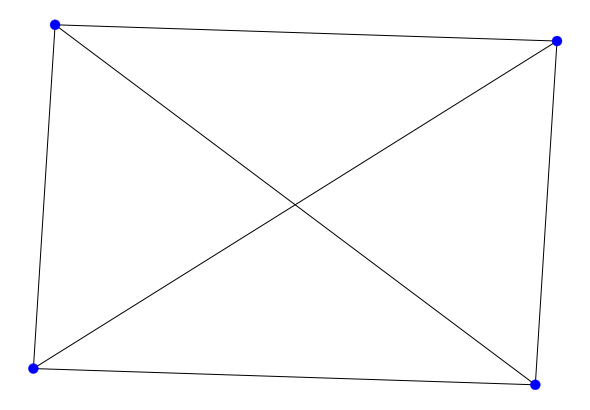

In [171]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph()  # 5x5 grid
G = G.to_undirected()
G = nx.complete_graph(4)

# G.add_edge(1,'ST_node')
# G.add_edge(2,'ST_node')
# G.add_edge(3,'ST_node')
# G.add_edge(4,'ST_node')
# G.add_edge(5,'ST_node')

# print the adjacency list
# for line in nx.generate_adjlist(G):
#     print(line)
# write edgelist to grid.edgelist
nx.write_edgelist(G, path="grid.edgelist", delimiter=":")
# read edgelist from grid.edgelist
H = nx.read_edgelist(path="grid.edgelist", delimiter=":")

nx.draw(H, node_color=['blue']*4, node_size=[100]*4, cmap=plt.cm.Blues)
plt.show()

from network2tikz import plot
plot((H.nodes,H.edges),'network.tex')





In [172]:
!pip install network2tikz

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/mnt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [173]:
import networkx
import matplotlib.pyplot as plt
def plot_graph_properties(G_loaded, filename , dpi_=300):
    # get average degree of graph
    ########## NON WEIGHTED DEGREE ###########
    average_degree = [0]*288
    for i in range(288):
        neighbour_count = 0
        node_count = 0 
        n = 0
        for dummy in G_loaded[i]["backward"]:
            if 'ACT' in filename:
                if not (dummy < 20000000 or dummy >= 50000000): 
                    continue
            if 'PT' in filename:
                if not (dummy >= 30000000 and dummy < 50000000):
                    continue 
            n = len(G_loaded[i]["backward"][dummy])
            neighbour_count += (n - 1) * n/2
            node_count += n
        if node_count != 0:
            average_degree[i] = neighbour_count / node_count
        else: 
            average_degree[i] = 0
            
    y_axis_stuff = average_degree[:-1]    
    x_axis_stuff = list(range(287))

    plt.plot(x_axis_stuff, y_axis_stuff)
    plt.xlabel("Time of day(Unit: 5 minute intervals)")
    plt.ylabel("Average degree")

    with open('plot_data_average_degree_'+filename+'.csv','w') as f:
        csvwriter = csv.writer(f)
        csvwriter.writerow(["X axis stuff"] + x_axis_stuff)
        csvwriter.writerow(["Y_axis_stuff"]+y_axis_stuff)
    plt.savefig('Average degree_'+filename+'_.png', dpi=dpi_)
    plt.show()

    
    
    ############# WEIGHTED DEGREE ##############
    average_degree = [0]*288
    error_count = 0 
    for i in range(288):
        print (i)
        neighbour_count = 0
        node_count = 0 
        for dummy in G_loaded[i]["backward"]:
            n = len(G_loaded[i]["backward"][dummy])
            if 'ACT' in filename:
                if not (dummy < 20000000 or dummy >= 50000000): 
                    continue
            if 'PT' in filename:
                if not (dummy >= 30000000 and dummy < 50000000):
                    continue 
                    
            if dummy < 20000000 or dummy >= 50000000:    ### NODE ACTIVITY 
                assert(not(dummy>=50000000 and dummy<60000000 )) # should never happen
                if dummy >= 60000000 and dummy < 70000000:  # WORK 
                    area_of_this_dummy = node_wise_A[dummy - index_start['WORK_NODE']]
                elif dummy >= 70000000 and dummy < 80000000:  # EDUCATION :
                    area_of_this_dummy = node_wise_A[dummy - index_start['EDUCATION_NODE']]
                elif dummy >= 80000000 and dummy < 90000000:  # SHOPPING :
                    area_of_this_dummy = node_wise_A[dummy - index_start['SHOPPING_NODE']]
                elif dummy >= 90000000 and dummy < 100000000:  # OTHER :
                    area_of_this_dummy = node_wise_A[dummy - index_start['OTHER_NODE']]

#                 sigma = area_of_this_dummy * 0.048 * 0.01
#                 sigma_x = sigma
#                 sigma_y = sigma
#                 infectious_ppl = np.random.multivariate_normal([0,0], ([sigma_x,0],[0,sigma_y]), n)
#                 p_n = np.random.multivariate_normal([0,0], ([sigma_x,0],[0,sigma_y]), 1)
#                 d = np.sum((p_n - infectious_ppl)**2, axis = 1)
#                 try:
#                     mean_dist = np.mean(d**0.5)  
#                 except:
#                     error_count += 1
#                     mean_dist = 1
 
                r = (area_of_this_dummy / 3.14) ** 0.5 
                mean_dist = 128*r/(45*3.14)

            elif dummy >= 30000000 and dummy < 50000000:    ## PT 
                if dummy < 40000000:  # BUS
                    L = 2.759 # (A_bus * 1/4) ** 0.5 
                else: # MRT
                    L = 3.314 # (A_mrt_coach * 1/5) ** 0.5  
                mean_dist = L * 0.5014
            elif dummy < 30000000 and dummy >= 20000000:  ##HOME 
                mean_dist = 6.5
            
            
                    
            neighbour_count += ((n - 1) * (1/mean_dist)) ## assuming same distances(expected)
            node_count += n
        if node_count != 0:
            average_degree[i] = neighbour_count / node_count
        else: 
            average_degree[i] = 0
            
    y_axis_stuff = average_degree[:-1]    
    x_axis_stuff = list(range(287))

    plt.plot(x_axis_stuff, y_axis_stuff)
    plt.xlabel("Time of day(Unit: 5 minute intervals)")
    plt.ylabel("Average weighted degree")

    with open('plot_data_average_weighted_degree_'+filename+'.csv','w') as f:
        csvwriter = csv.writer(f)
        csvwriter.writerow(["X axis stuff"] + x_axis_stuff)
        csvwriter.writerow(["Y_axis_stuff"]+y_axis_stuff)
    plt.savefig('Average weighted degree_'+filename+'_.png', dpi=dpi_)
    print (error_count, " Error_count ")
    plt.show()
    
    
    ##############  DEGREE DISTRIBUTION ##############
    average_degree = [0]*288
    distribution = {}

    for i in range(6*12-1,24*12,3*12):
        neighbour_count = 0
        node_count = 0
        percentage_of_node_types = {}
        for dummy in G_loaded[i]["backward"]:
            n = len(G_loaded[i]["backward"][dummy])
            if 'ACT' in filename:    
                if not (dummy < 20000000 or dummy >= 50000000): 
                    continue
            if 'PT' in filename:
                if not (dummy >= 30000000 and dummy < 50000000):
                    continue 
                    
            if dummy < 20000000 or dummy >= 50000000:    ### NODE ACTIVITY 
                if 'NODE' not in percentage_of_node_types:
                    percentage_of_node_types['NODE'] = n
                else:
                    percentage_of_node_types['NODE'] += n
                if dummy >= 60000000 and dummy < 70000000:  # WORK 
                    area_of_this_dummy = node_wise_A[dummy - index_start['WORK_NODE']]
                elif dummy >= 70000000 and dummy < 80000000:  # EDUCATION :
                    area_of_this_dummy = node_wise_A[dummy - index_start['EDUCATION_NODE']]
                elif dummy >= 80000000 and dummy < 90000000:  # SHOPPING :
                    area_of_this_dummy = node_wise_A[dummy - index_start['SHOPPING_NODE']]
                elif dummy >= 90000000 and dummy < 100000000:  # OTHER :
                    area_of_this_dummy = node_wise_A[dummy - index_start['OTHER_NODE']]

#                 sigma = area_of_this_dummy * 0.048
#                 sigma_x = sigma
#                 sigma_y = sigma
#                 all_neighbors = np.random.multivariate_normal([0,0], ([sigma_x,0],[0,sigma_y]), n)
#                 p_n = np.array([0,0])
#                 d = np.sum((p_n - all_neighbors)**2, axis = 1)
#                 mean_dist = np.mean(d**0.5)  
                
                r = (area_of_this_dummy / 3.14) ** 0.5 
                mean_dist = 128*r/(45*3.14)

            elif dummy >= 30000000 and dummy < 50000000:    ## PT 
                if 'PT' not in percentage_of_node_types:
                    percentage_of_node_types['PT'] = n
                else:
                    percentage_of_node_types['PT'] += n
                    
                if dummy < 40000000:  # BUS
                    L = 2.759 # (A_bus * 1/4) ** 0.5 
                else: # MRT
                    L = 3.314 # (A_mrt_coach * 1/5) ** 0.5  
                mean_dist = L * 0.5014
            elif dummy < 30000000 and dummy >= 20000000:  ##HOME 
                mean_dist = 6.5
                if 'HOME' not in percentage_of_node_types:
                    percentage_of_node_types['HOME'] = n
                else:
                    percentage_of_node_types['HOME'] += n
            
            
            if i not in distribution:
                distribution[i] = []
            if n > 1 :
                for iii in range(n):
                    distribution[i].append((n-1)) ## assuming same distances(expected)
        s = sum(percentage_of_node_types.values())
        print ("Percentages of types of dummies @ Hour ", i//12)
        for key in percentage_of_node_types:
            print (key,':',round(percentage_of_node_types[key]/s*100,2))

    plt.show()
    ddd = {}
    for iii in range(6*12-1,24*12,3*12):
        dd = []
        count = 0 
        for jjj in range(len(distribution[iii])):
            if distribution[iii][jjj] < 30000:# and distribution[iii][jjj] > 1:
                dd.append(distribution[iii][jjj])
            else:
                count += 1
        print (count/len(distribution[iii])*100, " % data eliminated while constructing the histogram")
        plt.hist(dd, 30) 
        plt.show()
        print (iii//12, " Hour of day ")
        ddd[iii] = dd
#     plt.hist([ddd[6*12], ddd[9*12], ddd[12*12], ddd[15*12], ddd[18*12], ddd[21*12]], bins = 30, rwidth = 1, label=['6 AM', '9 AM','12:00 NOON', '3 PM', '6 PM', '9 PM'])
    plt.hist([ddd[6*12-1], ddd[12*12-1], ddd[18*12-1],ddd[24*12-1]], bins = 30, rwidth = 1, label=['6 AM', '12:00 Noon', '6 PM','00:00 Midnight'])    
    plt.legend(loc='upper right')
    plt.xlabel("Degree")
    plt.ylabel("Count")

#         print (distribution[iii])

    plt.savefig('Histogram of degree_'+filename+'_.png', dpi=dpi_)
    plt.show()
    with open('Histogram of degree_'+filename+'.pickle', 'wb') as handle:
        pickle.dump(distribution, handle, protocol=pickle.HIGHEST_PROTOCOL)        
    
                

In [174]:


import networkx
import matplotlib.pyplot as plt
def plot_graph_properties(G_loaded, filename ,which_graphs, dpi_=300):
    # get average degree of graph
    ########## NON WEIGHTED DEGREE ###########
    average_degree = [0]*288
    for i in range(288):
        neighbour_count = 0
        node_count = 0 
        n = 0
        for dummy in G_loaded[i]["backward"]:
            if 'ACT' == which_graphs:
                if not (dummy < 20000000 or dummy >= 50000000): 
                    continue
            if 'PT' == which_graphs:
                if not (dummy >= 30000000 and dummy < 50000000):
                    continue 
            if 'WORK' == which_graphs:
                if not (dummy >= 60000000 and dummy < 70000000):
                    continue 
            if 'EDUCATION' == which_graphs:
                if not (dummy >= 70000000 and dummy < 80000000):
                    continue 
            if 'SHOPPING' == which_graphs:
                if not (dummy >= 80000000 and dummy < 90000000):
                    continue 
            if 'OTHER' == which_graphs:
                if not (dummy >= 90000000 and dummy < 100000000):
                    continue                     
            n = len(G_loaded[i]["backward"][dummy])
            neighbour_count += (n - 1) * n/2
            node_count += n
        if node_count != 0:
            average_degree[i] = neighbour_count / node_count
        else: 
            average_degree[i] = 0
            
    y_axis_stuff = average_degree[:-1]    
    x_axis_stuff = list(range(287))

#     plt.plot(x_axis_stuff, y_axis_stuff)
#     plt.xlabel("Time of day(Unit: 5 minute intervals)")
#     plt.ylabel("Average degree")

#     with open('plot_data_average_degree_'+filename+'.csv','w') as f:
#         csvwriter = csv.writer(f)
#         csvwriter.writerow(["X axis stuff"] + x_axis_stuff)
#         csvwriter.writerow(["Y_axis_stuff"]+y_axis_stuff)
#     plt.savefig('Average degree_'+filename+'_.png', dpi=dpi_)
#     plt.show()
    with open('non_weighted_degree_'+which_graphs+'.pickle', 'wb') as handle:
        pickle.dump([x_axis_stuff, y_axis_stuff], handle, protocol=pickle.HIGHEST_PROTOCOL)   
    
    
    ############# WEIGHTED DEGREE ##############
    average_degree = [0]*288
    error_count = 0 
    for i in range(288):
        neighbour_count = 0
        node_count = 0 
        for dummy in G_loaded[i]["backward"]:
            n = len(G_loaded[i]["backward"][dummy])
            if 'ACT' == which_graphs:
                if not (dummy < 20000000 or dummy >= 50000000): 
                    continue
            if 'PT' == which_graphs:
                if not (dummy >= 30000000 and dummy < 50000000):
                    continue 
            if 'WORK' == which_graphs:
                if not (dummy >= 60000000 and dummy < 70000000):
                    continue 
            if 'EDUCATION' == which_graphs:
                if not (dummy >= 70000000 and dummy < 80000000):
                    continue 
            if 'SHOPPING' == which_graphs:
                if not (dummy >= 80000000 and dummy < 90000000):
                    continue 
            if 'OTHER' == which_graphs:
                if not (dummy >= 90000000 and dummy < 100000000):
                    continue                                         
            if dummy < 20000000 or dummy >= 50000000:    ### NODE ACTIVITY 
                assert(not(dummy>=50000000 and dummy<60000000 )) # should never happen
                if dummy >= 60000000 and dummy < 70000000:  # WORK 
                    area_of_this_dummy = node_wise_A[dummy - index_start['WORK_NODE']]
                elif dummy >= 70000000 and dummy < 80000000:  # EDUCATION :
                    area_of_this_dummy = node_wise_A[dummy - index_start['EDUCATION_NODE']]
                elif dummy >= 80000000 and dummy < 90000000:  # SHOPPING :
                    area_of_this_dummy = node_wise_A[dummy - index_start['SHOPPING_NODE']]
                elif dummy >= 90000000 and dummy < 100000000:  # OTHER :
                    area_of_this_dummy = node_wise_A[dummy - index_start['OTHER_NODE']]

#                 sigma = area_of_this_dummy * 0.048 * 0.01
#                 sigma_x = sigma
#                 sigma_y = sigma
#                 infectious_ppl = np.random.multivariate_normal([0,0], ([sigma_x,0],[0,sigma_y]), n)
#                 p_n = np.random.multivariate_normal([0,0], ([sigma_x,0],[0,sigma_y]), 1)
#                 d = np.sum((p_n - infectious_ppl)**2, axis = 1)
#                 try:
#                     mean_dist = np.mean(d**0.5)  
#                 except:
#                     error_count += 1
#                     mean_dist = 1
 
                r = (area_of_this_dummy / 3.14) ** 0.5 
                mean_dist = 128*r/(45*3.14)

            elif dummy >= 30000000 and dummy < 50000000:    ## PT 
                if dummy < 40000000:  # BUS
                    L = 2.759 * 4 # (A_bus * 1/4) ** 0.5 
                else: # MRT
                    L = 3.314 * 25  # (A_mrt_coach * 1/5) ** 0.5  
                mean_dist = L * 0.5014
            elif dummy < 30000000 and dummy >= 20000000:  ##HOME 
                mean_dist = 6.5
            
            
                    
            neighbour_count += ((n - 1) * (1/mean_dist)) ## assuming same distances(expected)
            node_count += n
        if node_count != 0:
            average_degree[i] = neighbour_count / node_count
        else: 
            average_degree[i] = 0
            
    y_axis_stuff = average_degree[:-1]    
    x_axis_stuff = list(range(287))
    with open('weighted_degree_'+which_graphs+'.pickle', 'wb') as handle:
        pickle.dump([x_axis_stuff, y_axis_stuff], handle, protocol=pickle.HIGHEST_PROTOCOL)        
    

                


# In[161]:


import networkx
import matplotlib.pyplot as plt
def plot_graph_properties_distribution(G_loaded, filename ,which_graphs, dpi_=300):
    # get average degree of graph

    
    ############# WEIGHTED DEGREE ##############
    average_degree = [0]*288
    error_count = 0 
    distribution = {}
    for i in range(288):
        distribution[i] = []
    for i in range(288):
        neighbour_count = 0
        node_count = 0 
        for dummy in G_loaded[i]["backward"]:
            n = len(G_loaded[i]["backward"][dummy])

            if 'PT' == which_graphs:
                if not (dummy >= 30000000 and dummy < 50000000):
                    continue 
            if 'WORK' == which_graphs:
                if not (dummy >= 60000000 and dummy < 70000000):
                    continue 
            if 'EDUCATION' == which_graphs:
                if not (dummy >= 70000000 and dummy < 80000000):
                    continue 
            if 'SHOPPING' == which_graphs:
                if not (dummy >= 80000000 and dummy < 90000000):
                    continue 
            if 'OTHER' == which_graphs:
                if not (dummy >= 90000000 and dummy < 100000000):
                    continue                                         
            if dummy < 20000000 or dummy >= 50000000:    ### NODE ACTIVITY 
                assert(not(dummy>=50000000 and dummy<60000000 )) # should never happen
                if dummy >= 60000000 and dummy < 70000000:  # WORK 
                    area_of_this_dummy = node_wise_A[dummy - index_start['WORK_NODE']]
                elif dummy >= 70000000 and dummy < 80000000:  # EDUCATION :
                    area_of_this_dummy = node_wise_A[dummy - index_start['EDUCATION_NODE']]
                elif dummy >= 80000000 and dummy < 90000000:  # SHOPPING :
                    area_of_this_dummy = node_wise_A[dummy - index_start['SHOPPING_NODE']]
                elif dummy >= 90000000 and dummy < 100000000:  # OTHER :
                    area_of_this_dummy = node_wise_A[dummy - index_start['OTHER_NODE']]


 
                r = (area_of_this_dummy / 3.14) ** 0.5 
                mean_dist = 128*r/(45*3.14)

            elif dummy >= 30000000 and dummy < 50000000:    ## PT 
                if dummy < 40000000:  # BUS
                    L = 2.759 * 4 # (A_bus * 1/4) ** 0.5 
                else: # MRT
                    L = 3.314 * 25 # (A_mrt_coach * 1/5) ** 0.5  
                mean_dist = L * 0.5014
            elif dummy < 30000000 and dummy >= 20000000:  ##HOME 
                mean_dist = 6.5
            
            
                    
            neighbour_count += ((n - 1) * (1/mean_dist)) ## assuming same distances(expected)
            node_count += n
            if n > 2:
                distribution[i].append([(1/mean_dist)]* (n-1))
            
            
    y_axis_stuff = average_degree[:-1]    
    with open('weighted_degree_distribution'+which_graphs+'.pickle', 'wb') as handle:
        pickle.dump(distribution, handle, protocol=pickle.HIGHEST_PROTOCOL)        
    


# In[181]:


import networkx
import matplotlib.pyplot as plt
def plot_graph_properties_distribution_non_weighted(G_loaded, filename ,which_graphs, dpi_=300):
    # get average degree of graph

    
    average_degree = [0]*288
    error_count = 0 
    distribution = {}
    for i in range(288):
        distribution[i] = []
    for i in range(288):
        neighbour_count = 0
        node_count = 0 
        for dummy in G_loaded[i]["backward"]:
            n = len(G_loaded[i]["backward"][dummy])

            if 'PT' == which_graphs:
                if not (dummy >= 30000000 and dummy < 50000000):
                    continue 
            if 'WORK' == which_graphs:
                if not (dummy >= 60000000 and dummy < 70000000):
                    continue 
            if 'EDUCATION' == which_graphs:
                if not (dummy >= 70000000 and dummy < 80000000):
                    continue 
            if 'SHOPPING' == which_graphs:
                if not (dummy >= 80000000 and dummy < 90000000):
                    continue 
            if 'OTHER' == which_graphs:
                if not (dummy >= 90000000 and dummy < 100000000):
                    continue                                         
                    
            
                    

            if n > 2:
                distribution[i].append(n - 1)
            
            
    y_axis_stuff = average_degree[:-1]    
    with open('non_weighted_degree_distribution'+which_graphs+'.pickle', 'wb') as handle:
        pickle.dump(distribution, handle, protocol=pickle.HIGHEST_PROTOCOL)        
    


# In[163]:


plot_graph_properties(G_loaded, '_AS_OTHER_FULLPOP_',which_graphs='OTHER', dpi_ = 600)
plot_graph_properties(G_loaded, '_AS_WORK_FULLPOP_',which_graphs='WORK', dpi_ = 600)
plot_graph_properties(G_loaded, '_AS_EDUCATION_FULLPOP_',which_graphs='EDUCATION', dpi_ = 600)
plot_graph_properties(G_loaded, '_AS_SHOPPING_FULLPOP_',which_graphs='SHOPPING', dpi_ = 600)
plot_graph_properties(G_loaded, '_AS_PT_FULLPOP_',which_graphs='PT', dpi_ = 600)
plot_graph_properties(G_loaded, '_AS_UNION_FULLPOP_',which_graphs='UNION', dpi_ = 600)


# In[168]:


a = 5
print (a)


# In[162]:


plot_graph_properties_distribution(G_loaded, '_AS_OTHER_FULLPOP_',which_graphs='OTHER', dpi_ = 600)
plot_graph_properties_distribution(G_loaded, '_AS_WORK_FULLPOP_',which_graphs='WORK', dpi_ = 600)
plot_graph_properties_distribution(G_loaded, '_AS_EDUCATION_FULLPOP_',which_graphs='EDUCATION', dpi_ = 600)
plot_graph_properties_distribution(G_loaded, '_AS_SHOPPING_FULLPOP_',which_graphs='SHOPPING', dpi_ = 600)
plot_graph_properties_distribution(G_loaded, '_AS_PT_FULLPOP_',which_graphs='PT', dpi_ = 600)
plot_graph_properties_distribution(G_loaded, '_AS_UNION_FULLPOP_',which_graphs='UNION', dpi_ = 600)


# In[182]:


plot_graph_properties_distribution_non_weighted(G_loaded, '_AS_OTHER_FULLPOP_',which_graphs='OTHER', dpi_ = 600)
plot_graph_properties_distribution_non_weighted(G_loaded, '_AS_WORK_FULLPOP_',which_graphs='WORK', dpi_ = 600)
plot_graph_properties_distribution_non_weighted(G_loaded, '_AS_EDUCATION_FULLPOP_',which_graphs='EDUCATION', dpi_ = 600)
plot_graph_properties_distribution_non_weighted(G_loaded, '_AS_SHOPPING_FULLPOP_',which_graphs='SHOPPING', dpi_ = 600)
plot_graph_properties_distribution_non_weighted(G_loaded, '_AS_PT_FULLPOP_',which_graphs='PT', dpi_ = 600)
plot_graph_properties_distribution_non_weighted(G_loaded, '_AS_UNION_FULLPOP_',which_graphs='UNION', dpi_ = 600)


# In[180]:




5


In [175]:
# create xticks
timeofdayticks = []
for i in range(288//2):
    if i%12 == 0:
        timeofdayticks.append(str(i//12)+':00 AM')
    else:
        timeofdayticks.append('     ')
for i in range(288//2,288):
    if i%12==0:
        timeofdayticks.append(str(i//12 -12 )+':00 PM')
    else:
        timeofdayticks.append('     ')
print (timeofdayticks)

['0:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '1:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '2:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '3:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '4:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '5:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '6:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '7:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '8:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '9:00 AM'

In [176]:
timeofdayticks = ['0:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '3:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '6:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '9:00 AM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '12:00 PM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '3:00 PM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '6:00 PM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '9:00 PM', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ']

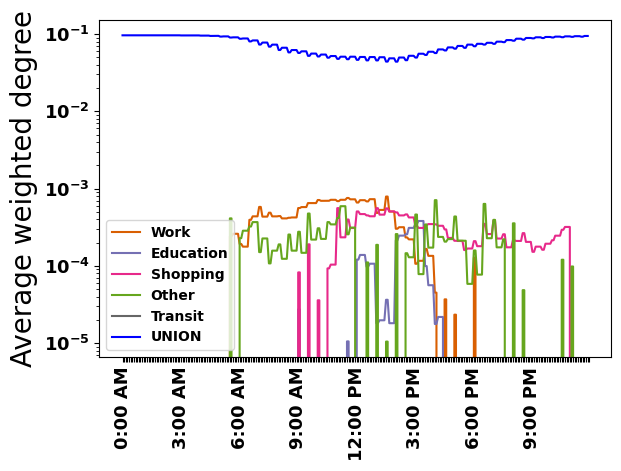

In [177]:
# plot curves foor graph

# mpl.style.use('seaborn')
import matplotlib as mpl
mpl.rc_file_defaults()

font = {'weight' : 'bold',
        'size'   : 13}

mpl.rc('font', **font)




colormap = {'H':'#1b9e77','W':'#d95f02','E':'#7570b3','S':'#e7298a','O':'#66a61e','B':'#e6ab02','M':'#a6761d','Bus+MRT':'#666666'}
with open('weighted_degree_WORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
plt.plot(range(len(WORK[1])), WORK[1], c = colormap['W'], label='Work')

with open('weighted_degree_EDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
plt.plot(range(len(EDUCATION[1])), EDUCATION[1], c = colormap['E'], label='Education')

with open('weighted_degree_SHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
plt.plot(range(len(SHOPPING[1])), SHOPPING[1], c = colormap['S'], label='Shopping')

with open('weighted_degree_OTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
plt.plot(range(len(OTHER[1])), OTHER[1], c = colormap['O'], label='Other')

with open('weighted_degree_PT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
plt.plot(range(len(PT[1])), PT[1], c = colormap['Bus+MRT'], label='Transit')

with open('weighted_degree_UNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
plt.plot(range(len(UNION[1])), UNION[1], c = 'b', label='UNION')
# plt.legend(fontsize =10)
plt.legend(fontsize =10)
# plt.grid()
plt.yscale('log')
# plt.xlabel('Time of day(5 minute intervals)', fontsize=20)
# plt.ylabel('Average weighted degree', fontsize=20)
plt.ylabel('Average weighted degree', fontsize=20)

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=90)  # Set text labels.
plt.tight_layout()
plt.savefig('weighted_degrees.png',dpi=600)
plt.show()



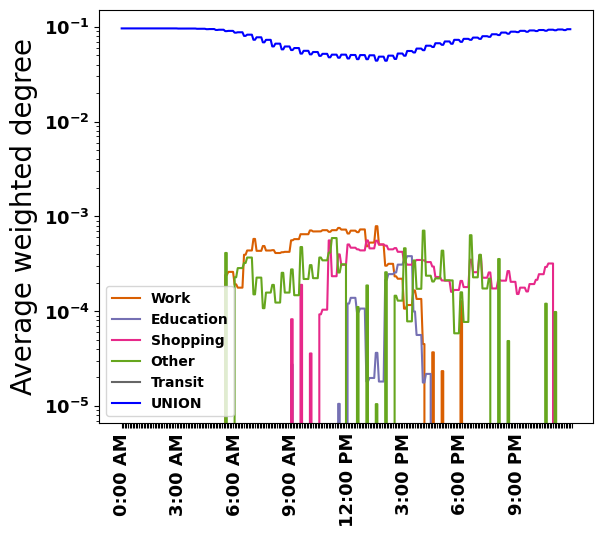

In [178]:
# plot curves foor graph

# mpl.style.use('seaborn')
import matplotlib as mpl
# font = {'weight' : 'bold',
#         'size'   : 13}

# mpl.rc('font', **font)
# mpl.rc_file_defaults()




colormap = {'H':'#1b9e77','W':'#d95f02','E':'#7570b3','S':'#e7298a','O':'#66a61e','B':'#e6ab02','M':'#a6761d','Bus+MRT':'#666666'}
with open('weighted_degree_WORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
plt.plot(range(len(WORK[1])), WORK[1], c = colormap['W'], label='Work')

with open('weighted_degree_EDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
plt.plot(range(len(EDUCATION[1])), EDUCATION[1], c = colormap['E'], label='Education')

with open('weighted_degree_SHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
plt.plot(range(len(SHOPPING[1])), SHOPPING[1], c = colormap['S'], label='Shopping')

with open('weighted_degree_OTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
plt.plot(range(len(OTHER[1])), OTHER[1], c = colormap['O'], label='Other')

with open('weighted_degree_PT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
plt.plot(range(len(PT[1])), PT[1], c = colormap['Bus+MRT'], label='Transit')

with open('weighted_degree_UNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
plt.plot(range(len(UNION[1])), UNION[1], c = 'b', label='UNION')
# plt.legend(fontsize =10)
plt.legend(fontsize =10)
# plt.grid()
plt.yscale('log')
# plt.xlabel('Time of day(5 minute intervals)', fontsize=20)
# plt.ylabel('Average weighted degree', fontsize=20)
plt.ylabel('Average weighted degree', fontsize=20)
plt.tight_layout()
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=90)  # Set text labels.

plt.savefig('weighted_degrees.png',dpi=600)
plt.show()



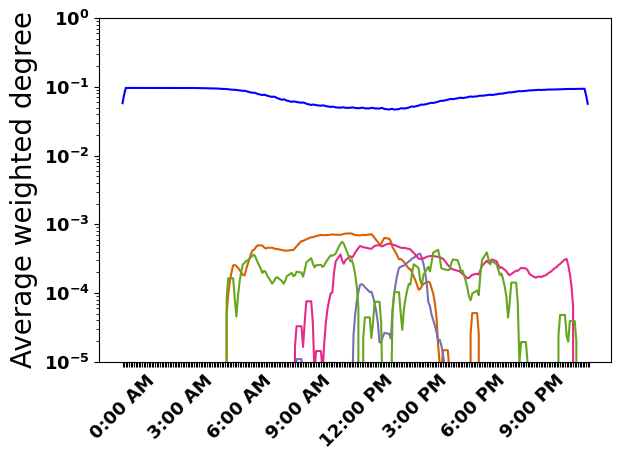

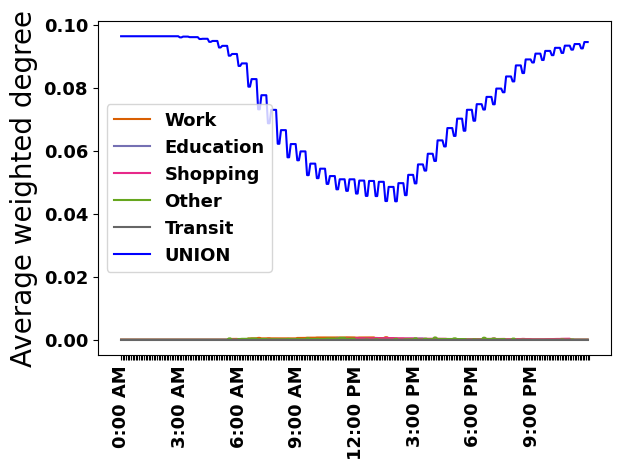

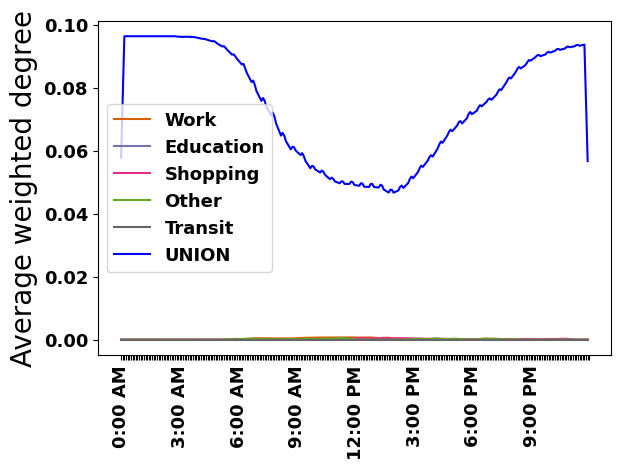

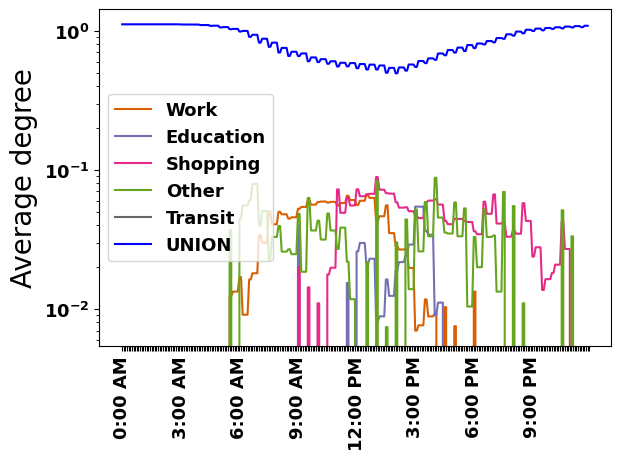

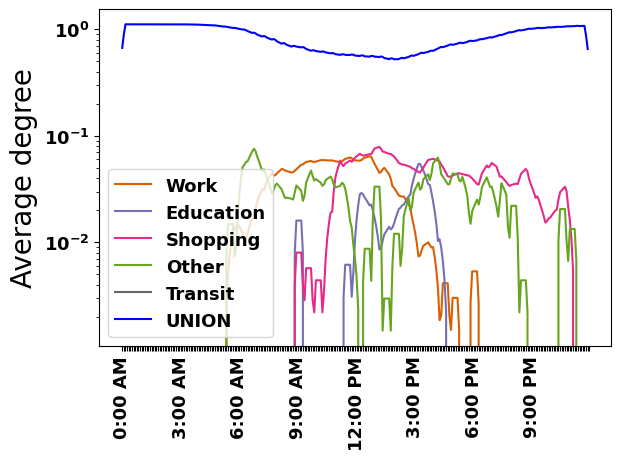

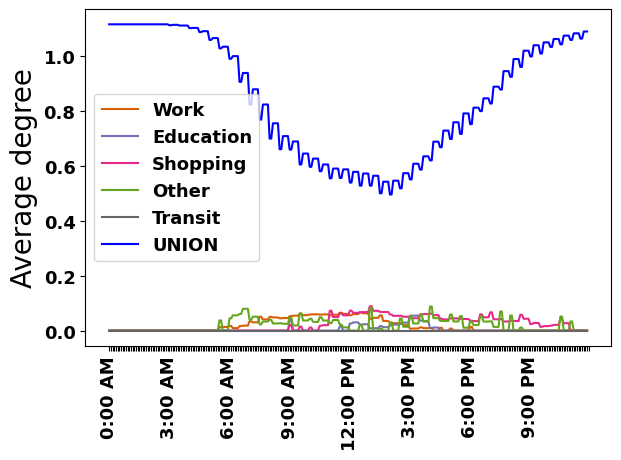

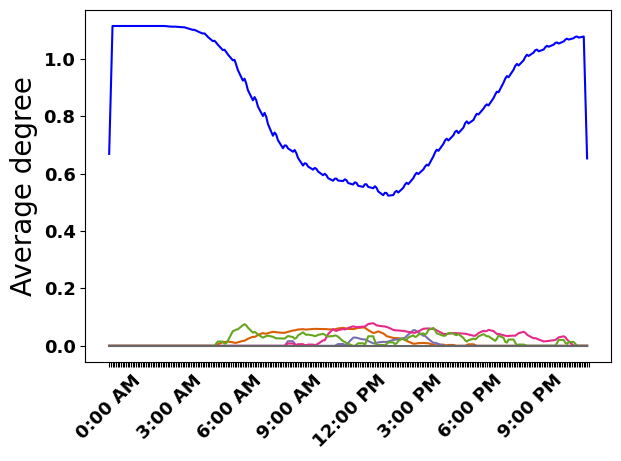

In [179]:
# mpl.style.use('seaborn')
import matplotlib as mpl
import pickle
import numpy as np
import matplotlib.pyplot as plt

mpl.rc_file_defaults()

font = {'weight' : 'bold',
        'size'   : 13}

mpl.rc('font', **font)

colormap = {'H':'#1b9e77','W':'#d95f02','E':'#7570b3','S':'#e7298a','O':'#66a61e','B':'#e6ab02','M':'#a6761d','Bus+MRT':'#666666'}

with open('weighted_degree_WORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
vals = np.convolve(WORK[1], np.ones((5,))/5, mode='same')
plt.plot(range(len(WORK[1])),vals, c = colormap['W'], label='Work')

with open('weighted_degree_EDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
vals = np.convolve(EDUCATION[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(EDUCATION[1])), vals, c = colormap['E'], label='Education')

with open('weighted_degree_SHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
vals = np.convolve(SHOPPING[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(SHOPPING[1])), vals, c = colormap['S'], label='Shopping')

with open('weighted_degree_OTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
vals = np.convolve(OTHER[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(OTHER[1])), vals, c = colormap['O'], label='Other')

with open('weighted_degree_PT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
vals = np.convolve(PT[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(PT[1])), vals, c = colormap['Bus+MRT'], label='Transit')

with open('weighted_degree_UNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
vals = np.convolve(UNION[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(UNION[1])), vals, c = 'b', label='UNION')
# plt.legend(loc='lower center', fontsize=10)
# plt.xlabel('Time of day(5 minute intervals)')
plt.ylabel('Average weighted degree', fontsize =20)
# plt.grid()
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=45)  # Set text labels.
plt.yscale('log')
plt.ylim(1e-5,1)
plt.tight_layout()
plt.savefig('weighted_degrees_smoothed.png',dpi=600)
plt.show()


colormap = {'H':'#1b9e77','W':'#d95f02','E':'#7570b3','S':'#e7298a','O':'#66a61e','B':'#e6ab02','M':'#a6761d','Bus+MRT':'#666666'}
with open('weighted_degree_WORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
plt.plot(range(len(WORK[1])), WORK[1], c = colormap['W'], label='Work')

with open('weighted_degree_EDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
plt.plot(range(len(EDUCATION[1])), EDUCATION[1], c = colormap['E'], label='Education')

with open('weighted_degree_SHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
plt.plot(range(len(SHOPPING[1])), SHOPPING[1], c = colormap['S'], label='Shopping')

with open('weighted_degree_OTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
plt.plot(range(len(OTHER[1])), OTHER[1], c = colormap['O'], label='Other')

with open('weighted_degree_PT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
plt.plot(range(len(PT[1])), PT[1], c = colormap['Bus+MRT'], label='Transit')

with open('weighted_degree_UNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
plt.plot(range(len(UNION[1])), UNION[1], c = 'b', label='UNION')
plt.legend()
plt.yscale('linear')
# plt.xlabel('Time of day(5 minute intervals)')
plt.ylabel('Average weighted degree',fontsize=20)
# plt.grid()
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=90)  # Set text labels.
plt.tight_layout()
plt.savefig('weighted_degrees_linear.png',dpi=600)
plt.show()



with open('weighted_degree_WORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
vals = np.convolve(WORK[1], np.ones((5,))/5, mode='same')
plt.plot(range(len(WORK[1])),vals, c = colormap['W'], label='Work')

with open('weighted_degree_EDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
vals = np.convolve(EDUCATION[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(EDUCATION[1])), vals, c = colormap['E'], label='Education')

with open('weighted_degree_SHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
vals = np.convolve(SHOPPING[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(SHOPPING[1])), vals, c = colormap['S'], label='Shopping')

with open('weighted_degree_OTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
vals = np.convolve(OTHER[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(OTHER[1])), vals, c = colormap['O'], label='Other')

with open('weighted_degree_PT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
vals = np.convolve(PT[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(PT[1])), vals, c = colormap['Bus+MRT'], label='Transit')

with open('weighted_degree_UNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
vals = np.convolve(UNION[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(UNION[1])), vals, c = 'b', label='UNION')
plt.legend()
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=90)  # Set text labels.
plt.yscale('linear')
# plt.xlabel('Time of day(5 minute intervals)')
plt.ylabel('Average weighted degree', fontsize=20)
# plt.grid()
plt.tight_layout()
plt.savefig('weighted_degrees_smoothed_linear.png',dpi=600)
plt.show()


# In[184]:


# plot curves foor graph

# mpl.style.use('seaborn')
# mpl.rc_file_defaults()

colormap = {'H':'#1b9e77','W':'#d95f02','E':'#7570b3','S':'#e7298a','O':'#66a61e','B':'#e6ab02','M':'#a6761d','Bus+MRT':'#666666'}
with open('non_weighted_degree_WORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
plt.plot(range(len(WORK[1])), WORK[1], c = colormap['W'], label='Work')

with open('non_weighted_degree_EDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
plt.plot(range(len(EDUCATION[1])), EDUCATION[1], c = colormap['E'], label='Education')

with open('non_weighted_degree_SHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
plt.plot(range(len(SHOPPING[1])), SHOPPING[1], c = colormap['S'], label='Shopping')

with open('non_weighted_degree_OTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
plt.plot(range(len(OTHER[1])), OTHER[1], c = colormap['O'], label='Other')

with open('non_weighted_degree_PT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
plt.plot(range(len(PT[1])), PT[1], c = colormap['Bus+MRT'], label='Transit')

with open('non_weighted_degree_UNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
plt.plot(range(len(UNION[1])), UNION[1], c = 'b', label='UNION')
plt.legend()
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=90)  # Set text labels.
# plt.grid()
plt.yscale('log')
# plt.xlabel('Time of day(5 minute intervals)')
plt.ylabel('Average degree', fontsize=20)
plt.tight_layout()
plt.savefig('non_weighted_degrees.png',dpi=600)
plt.show()



with open('non_weighted_degree_WORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
vals = np.convolve(WORK[1], np.ones((5,))/5, mode='same')
plt.plot(range(len(WORK[1])),vals, c = colormap['W'], label='Work')

with open('non_weighted_degree_EDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
vals = np.convolve(EDUCATION[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(EDUCATION[1])), vals, c = colormap['E'], label='Education')

with open('non_weighted_degree_SHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
vals = np.convolve(SHOPPING[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(SHOPPING[1])), vals, c = colormap['S'], label='Shopping')

with open('non_weighted_degree_OTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
vals = np.convolve(OTHER[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(OTHER[1])), vals, c = colormap['O'], label='Other')

with open('non_weighted_degree_PT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
vals = np.convolve(PT[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(PT[1])), vals, c = colormap['Bus+MRT'], label='Transit')

with open('non_weighted_degree_UNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
vals = np.convolve(UNION[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(UNION[1])), vals, c = 'b', label='UNION')
plt.legend()
# plt.xlabel('Time of day(5 minute intervals)')
plt.ylabel('Average degree', fontsize=20)
# plt.grid()
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=90)  # Set text labels.
plt.yscale('log')
plt.tight_layout()
plt.savefig('non_weighted_degrees_smoothed.png',dpi=600)
plt.show()


colormap = {'H':'#1b9e77','W':'#d95f02','E':'#7570b3','S':'#e7298a','O':'#66a61e','B':'#e6ab02','M':'#a6761d','Bus+MRT':'#666666'}
with open('non_weighted_degree_WORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
plt.plot(range(len(WORK[1])), WORK[1], c = colormap['W'], label='Work')

with open('non_weighted_degree_EDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
plt.plot(range(len(EDUCATION[1])), EDUCATION[1], c = colormap['E'], label='Education')

with open('non_weighted_degree_SHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
plt.plot(range(len(SHOPPING[1])), SHOPPING[1], c = colormap['S'], label='Shopping')

with open('non_weighted_degree_OTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
plt.plot(range(len(OTHER[1])), OTHER[1], c = colormap['O'], label='Other')

with open('non_weighted_degree_PT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
plt.plot(range(len(PT[1])), PT[1], c = colormap['Bus+MRT'], label='Transit')

with open('non_weighted_degree_UNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
plt.plot(range(len(UNION[1])), UNION[1], c = 'b', label='UNION')
plt.legend()
plt.yscale('linear')
# plt.xlabel('Time of day(5 minute intervals)')
plt.ylabel('Average degree', fontsize=20)
# plt.grid()
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=90)  # Set text labels.
plt.tight_layout()
plt.savefig('non_weighted_degrees_linear.png',dpi=600)
plt.show()



with open('non_weighted_degree_WORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
vals = np.convolve(WORK[1], np.ones((5,))/5, mode='same')
plt.plot(range(len(WORK[1])),vals, c = colormap['W'], label='Work')

with open('non_weighted_degree_EDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
vals = np.convolve(EDUCATION[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(EDUCATION[1])), vals, c = colormap['E'], label='Education')

with open('non_weighted_degree_SHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
vals = np.convolve(SHOPPING[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(SHOPPING[1])), vals, c = colormap['S'], label='Shopping')

with open('non_weighted_degree_OTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
vals = np.convolve(OTHER[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(OTHER[1])), vals, c = colormap['O'], label='Other')

with open('non_weighted_degree_PT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
vals = np.convolve(PT[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(PT[1])), vals, c = colormap['Bus+MRT'], label='Transit')

with open('non_weighted_degree_UNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
vals = np.convolve(UNION[1], np.ones((5,))/5, mode='same')    
plt.plot(range(len(UNION[1])), vals, c = 'b', label='UNION')
# plt.legend()
plt.yscale('linear')
# plt.xlabel('Time of day(5 minute intervals)')
plt.ylabel('Average degree', fontsize = 20)
# plt.grid()
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=45)  # Set text labels.
plt.tight_layout()
plt.savefig('non_weighted_degrees_smoothed_linear_v3.png',dpi=600)
plt.show()



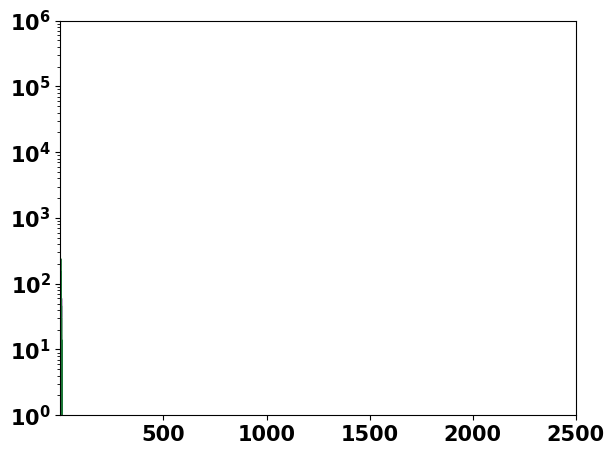

In [180]:

# In[199]:


# plot curves foor graph

# mpl.style.use('seaborn')
# mpl.rc_file_defaults()
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import numpy as np
import seaborn as sns
colors = sns.color_palette('husl',8)

font = {'weight' : 'bold',
        'size'   : 15} 

mpl.rc('font', **font)

colormap = {}
for i in range(8):
    colormap[i] = colors[i]

colormap = {0:'#762a83',1:'#9970ab',2:'#c2a5cf',3:'#e7d4e8',4:'#d9f0d3',5:'#a6dba0',6:'#5aae61',7:'#1b7837'}
with open('non_weighted_degree_distributionWORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 

with open('non_weighted_degree_distributionEDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 

with open('non_weighted_degree_distributionSHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 

with open('non_weighted_degree_distributionOTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 

with open('non_weighted_degree_distributionPT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 

with open('non_weighted_degree_distributionUNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 

def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

    
# combine W/E/S/O to get activity
act = {}
for key in WORK:
    act[key] = WORK[key] + EDUCATION[key] + SHOPPING[key] + OTHER[key]  ## appending all lists to create one big list

for key in range(0,288,12*3):
    counts_, bins_ = np.histogram(UNION[key], 10)
    plt.plot(bins_[:-1], (counts_), c=colormap[key//(12*3)], label=timeofdayticks[key])

plt.yscale('log')    
# plt.xscale('log')
# plt.legend(fontsize=20)
plt.tight_layout()
plt.ylim(1,1e6)
plt.xlim(1,2500)
# locs, labels = plt.xticks()  # Get the current locations and labels.
# plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
# plt.xticks(np.arange(288), timeofdayticks, rotation=90)  # Set text labels.
plt.tight_layout()
plt.savefig('AI_histogram_3_hours_linear'+str(key)+'.png', dpi = 600)
plt.show()




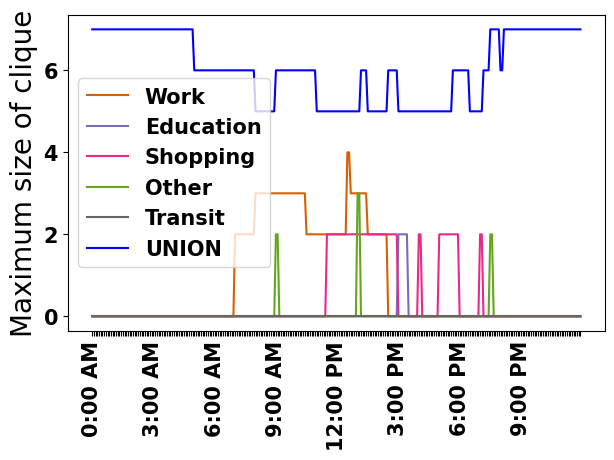

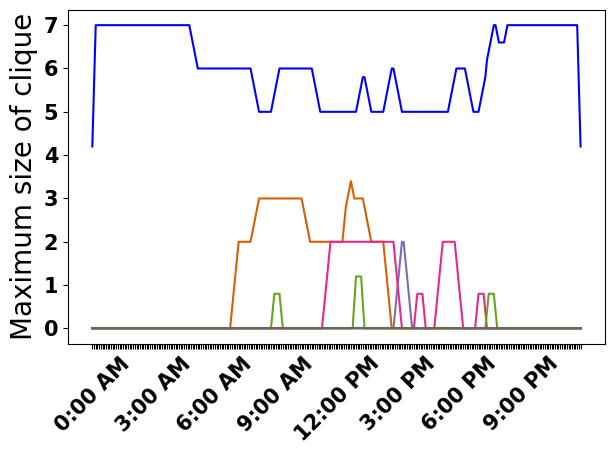

In [181]:




# In[206]:


# max size of component every minute

colormap = {'H':'#1b9e77','W':'#d95f02','E':'#7570b3','S':'#e7298a','O':'#66a61e','B':'#e6ab02','M':'#a6761d','Bus+MRT':'#666666'}
with open('non_weighted_degree_distributionWORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
for key in WORK:
    if len(WORK[key]) != 0:
        WORK[key] = max(WORK[key])
    else:
        WORK[key] = 0
a = []
for key in range(288):
    a.append(WORK[key])
plt.plot(range(len(a)),a,c=colormap['W'],label = 'Work')

        
    
with open('non_weighted_degree_distributionEDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
for key in EDUCATION:
    if len(EDUCATION[key]) != 0:
        EDUCATION[key] = max(EDUCATION[key])
    else:
        EDUCATION[key] = 0
a = []
for key in range(288):
    a.append(EDUCATION[key])
plt.plot(range(len(a)),a,c=colormap['E'],label = 'Education')



with open('non_weighted_degree_distributionSHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
for key in SHOPPING:
    if len(SHOPPING[key]) != 0:
        SHOPPING[key] = max(SHOPPING[key])
    else:
        SHOPPING[key] = 0
a = []
for key in range(288):
    a.append(SHOPPING[key])
plt.plot(range(len(a)),a,c=colormap['S'],label = 'Shopping')    



with open('non_weighted_degree_distributionOTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
for key in OTHER:
    if len(OTHER[key]) != 0:
        OTHER[key] = max(OTHER[key])
    else:
        OTHER[key] = 0
a = []
for key in range(288):
    a.append(OTHER[key])
plt.plot(range(len(a)),a,c=colormap['O'],label = 'Other')    



with open('non_weighted_degree_distributionPT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
for key in PT:
    if len(PT[key]) != 0:
        PT[key] = max(PT[key])
    else:
        PT[key] = 0
a = []
for key in range(288):
    a.append(PT[key])
plt.plot(range(len(a)),a,c=colormap['Bus+MRT'],label = 'Transit')
        
    
    
with open('non_weighted_degree_distributionUNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
for key in UNION:
    if len(UNION[key]) != 0:
        UNION[key] = max(UNION[key])
    else:
        UNION[key] = 0
a = []
for key in range(288):        
    a.append(UNION[key])
plt.plot(range(len(a)),a,c='b',label = 'UNION')



plt.legend()
plt.yscale('linear')
# plt.xlabel('Time of day(5 minute intervals)')
plt.ylabel('Maximum size of clique',fontsize=20)
# plt.grid()
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=90)  # Set text labels.
plt.tight_layout()
plt.savefig('max_size_clique.png',dpi=600)
plt.show()
########################################. SMOOTHED ###########
a = np.convolve(a, np.ones((5,))/5, mode='same')    
with open('non_weighted_degree_distributionWORK'+'.pickle','rb') as handle:
    WORK = pickle.load(handle) 
for key in WORK:
    if len(WORK[key]) != 0:
        WORK[key] = max(WORK[key])
    else:
        WORK[key] = 0
a = []
for key in range(288):
    a.append(WORK[key])
a = np.convolve(a, np.ones((5,))/5, mode='same')    
plt.plot(range(len(a)),a,c=colormap['W'],label = 'Work')

        
    
with open('non_weighted_degree_distributionEDUCATION'+'.pickle','rb') as handle:
    EDUCATION = pickle.load(handle) 
for key in EDUCATION:
    if len(EDUCATION[key]) != 0:
        EDUCATION[key] = max(EDUCATION[key])
    else:
        EDUCATION[key] = 0
a = []
for key in range(288):
    a.append(EDUCATION[key])
a = np.convolve(a, np.ones((5,))/5, mode='same')        
plt.plot(range(len(a)),a,c=colormap['E'],label = 'Education')



with open('non_weighted_degree_distributionSHOPPING'+'.pickle','rb') as handle:
    SHOPPING = pickle.load(handle) 
for key in SHOPPING:
    if len(SHOPPING[key]) != 0:
        SHOPPING[key] = max(SHOPPING[key])
    else:
        SHOPPING[key] = 0
a = []
for key in range(288):
    a.append(SHOPPING[key])
a = np.convolve(a, np.ones((5,))/5, mode='same')        
plt.plot(range(len(a)),a,c=colormap['S'],label = 'Shopping')    



with open('non_weighted_degree_distributionOTHER'+'.pickle','rb') as handle:
    OTHER = pickle.load(handle) 
for key in OTHER:
    if len(OTHER[key]) != 0:
        OTHER[key] = max(OTHER[key])
    else:
        OTHER[key] = 0
a = []
for key in range(288):
    a.append(OTHER[key])
a = np.convolve(a, np.ones((5,))/5, mode='same')        
plt.plot(range(len(a)),a,c=colormap['O'],label = 'Other')    



with open('non_weighted_degree_distributionPT'+'.pickle','rb') as handle:
    PT = pickle.load(handle) 
for key in PT:
    if len(PT[key]) != 0:
        PT[key] = max(PT[key])
    else:
        PT[key] = 0
a = []
for key in range(288):
    a.append(PT[key])
a = np.convolve(a, np.ones((5,))/5, mode='same')        
plt.plot(range(len(a)),a,c=colormap['Bus+MRT'],label = 'Transit')
        
    
    
with open('non_weighted_degree_distributionUNION'+'.pickle','rb') as handle:
    UNION = pickle.load(handle) 
for key in UNION:
    if len(UNION[key]) != 0:
        UNION[key] = max(UNION[key])
    else:
        UNION[key] = 0
a = []
for key in range(288):        
    a.append(UNION[key])
a = np.convolve(a, np.ones((5,))/5, mode='same')        
plt.plot(range(len(a)),a,c='b',label = 'UNION')



# plt.legend()
plt.yscale('linear')
# plt.xlabel('Time of day(5 minute intervals)')
plt.ylabel('Maximum size of clique', fontsize=20)
# plt.grid()
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 1, step=0.2))  # Set label locations.
plt.xticks(np.arange(288), timeofdayticks, rotation=45)  # Set text labels.
plt.tight_layout()
plt.savefig('max_size_clique_smoothed_45.png',dpi=600)
plt.show()


# In[ ]:






In [182]:
# get mode shares from DAS
modes_share = {}
das = []
with open('AI_demand_BC') as f:
    next(f)
    for row in f:
        listed = row.strip().split(',')
        stop_mode = listed[7]
        if stop_mode in modes_share:
            modes_share[stop_mode] += 1
        else:
            modes_share[stop_mode] = 1
        das.append(listed)
            
s = sum(modes_share.values())
for mode in modes_share:

    print (mode, round(modes_share[mode]/s*100,2), modes_share[mode],'%')



Car Sharing 3 15.06 2405204 %
Car Sharing 2 19.31 3082673 %
Car 44.46 7099736 %
PrivateBus 0.43 68843 %
Walk 3.74 596495 %
SMS 3.84 613761 %
Motorcycle 1.22 194635 %
BusTravel 9.9 1581258 %
Bike 1.08 171675 %
Taxi 0.96 153025 %


20.25 :[ 2.97 , 156228 ],20.75 :[ 2.49 , 130731 ],13.75 :[ 3.73 , 196249 ],17.75 :[ 4.07 , 214156 ],11.25 :[ 2.44 , 128053 ],9.75 :[ 1.88 , 98927 ],15.75 :[ 4.59 , 241161 ],8.75 :[ 1.96 , 102840 ],14.75 :[ 4.29 , 225634 ],10.75 :[ 2.19 , 115271 ],11.75 :[ 2.73 , 143389 ],16.25 :[ 4.54 , 238605 ],18.75 :[ 3.74 , 196685 ],18.25 :[ 3.89 , 204319 ],23.25 :[ 0.78 , 41201 ],7.25 :[ 1.43 , 75231 ],10.25 :[ 1.98 , 104100 ],13.25 :[ 3.51 , 184287 ],23.75 :[ 0.61 , 32239 ],22.75 :[ 1.32 , 69454 ],12.75 :[ 3.25 , 171076 ],22.25 :[ 1.44 , 75575 ],17.25 :[ 4.25 , 223486 ],16.75 :[ 4.44 , 233485 ],19.25 :[ 3.59 , 188601 ],9.25 :[ 1.85 , 97348 ],19.75 :[ 3.35 , 176031 ],5.25 :[ 0.06 , 3345 ],8.25 :[ 2.1 , 110396 ],7.75 :[ 2.03 , 106703 ],15.25 :[ 4.5 , 236785 ],12.25 :[ 3.01 , 158254 ],6.75 :[ 0.71 , 37110 ],14.25 :[ 4.03 , 211616 ],21.75 :[ 1.7 , 89237 ],21.25 :[ 2.05 , 107592 ],5.75 :[ 0.13 , 6657 ],25.25 :[ 0.3 , 15735 ],25.75 :[ 0.26 , 13834 ],24.25 :[ 0.48 , 25277 ],26.75 :[ 0.32 , 16578 ],24.75

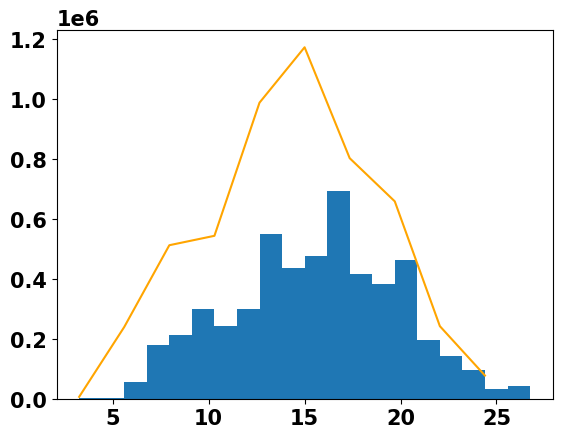

In [183]:

# trip start time
trip_start_time = []
for i in range(len(das)):
    if das[i][4] !='Home':
        continue
    trip_start_time.append(float(das[i][13]))
startTimeDict = {}
for t in trip_start_time:
    if t not in startTimeDict:
        startTimeDict[t] = 1
    else:
        startTimeDict[t] += 1
plt.hist(trip_start_time,20)
for key in startTimeDict:
    print (key,':[',round(startTimeDict[key]/sum(startTimeDict.values())*100,2),',', startTimeDict[key],'],',end='')
counts_, bins_ = np.histogram(trip_start_time, 10)
plt.plot(bins_[:-1], (counts_), color='orange', label='AS')    

In [184]:
 
node_lat_lon = {}
node_dict = {}
with open('AI_node_lat_lon.csv') as f:
    for row in f:
        listed = row.strip().split(',')
        node_lat_lon[int(listed[0])] = [float(listed[1]), float(listed[2])]

node_wise_dict_of_act = {}
for i in range(len(das)):
    if int(das[i][5]) in node_wise_dict_of_act:
        node_wise_dict_of_act[int(das[i][5])].append(das[i][4])
    else:
        node_wise_dict_of_act[int(das[i][5])]= [das[i][4]]

import collections    
for key in node_wise_dict_of_act:
    counter=collections.Counter(node_wise_dict_of_act[key])
    if 'Home' not in counter:
        counter['Home'] = 0
    if 'Shop' not in counter:
        counter['Shop'] = 0 
    if 'Education' not in counter:
        counter['Education'] = 0
    if 'Other' not in counter:
        counter['Other'] = 0
    if 'Work' not in counter:
        counter['Work'] = 0        
    node_wise_dict_of_act[key] = counter
    
        
with open('node_wise_city_characeristics.csv','w') as f:       
    csvwriter = csv.writer(f)
    csvwriter.writerow(['lat','lon','Home','Work','Education','Shopping','Other'])
    for key in node_wise_dict_of_act:
        try:
            csvwriter.writerow([node_lat_lon[key][1], node_lat_lon[key][0], node_wise_dict_of_act[key]['Home'], node_wise_dict_of_act[key]['Work'], node_wise_dict_of_act[key]['Education'], node_wise_dict_of_act[key]['Shop'], node_wise_dict_of_act[key]['Other']])
        except:
            print ("Missing node id ", key)
            continue

Missing node id  0
Missing node id  8165


In [185]:
node_lat_lon[key]

[-71.582521, 42.483176]